# Máster Universitario en Inteligencia Artificial

**Universidad Internacional de La Rioja (UNIR)**

## Predicción de la satisfacción del cliente en el servicio de internet de alta velocidad de ETB, mediante aprendizaje automático
***
**Presentado por**: Torres Reina, Roger Neil

**Director**: Pedraza Gomara, Luis

**Ciudad**: Bogotá

**Fecha**: 14 septiembre de 2022
***

# 5. Desarrollo de la comparativa

**Comparativa de soluciones. Árboles, Random Forest y Máquina de Vector de Soporte (SVM).**

## Librerías utilizadas

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from mlxtend.plotting import plot_decision_regions
from matplotlib import style
from six import StringIO  
from IPython.display import Image  
import pydotplus
import matplotlib.ticker as ticker

 # Preprocesado y modelado
# ==============================================================================

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler



# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

* Se crean las constantes que serán utilizadas para el desarrollo de la comparativa. Por ejemplo, el valor de la semilla aleatoria y otras variables.
* Para mostar toda la lista de frecuencias max_mostrar_frecuencias = 0
* Se crea función para gráficar los resultados de Accuracy

In [2]:
# Creación de variables y funciones a usar en la comparación de soluciones
# ==============================================================================
semilla_aleatoria = 1234
cons_no_asignado="NoAsignado"
max_mostrar_frecuencias = 0

def graficar_accuracy_scores(estimator, train_x, train_y,test_x,test_y,nparts=5,jobs=None):
    kfold = KFold(n_splits=nparts,shuffle=True, random_state=semilla_aleatoria)
    fig,axes = plt.subplots(figsize=(7, 3))
    axes.set_title("Ratio de éxito(Accuracy)/Nro. Fold")
    axes.set_xlabel("Nro. Fold")
    axes.set_ylabel("Accuracy")    
    train_scores = cross_val_score(estimator, train_x,train_y, cv = kfold, n_jobs=jobs, scoring="accuracy")
    test_scores = cross_val_score(estimator, test_x, test_y, cv = kfold, n_jobs=jobs, scoring="accuracy")        
    train_sizes = range(1,nparts+1,1)    
    axes.grid()    
    axes.plot(train_sizes, train_scores, 'o-', color="r",label="Datos Entrenamiento")
    axes.plot(train_sizes, test_scores, 'o-', color="g",label="Validacion Cruzada")
    axes.legend(loc="best")
    return train_scores

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

# 5.1. Entendimiento del negocio

ETB definió como uno de los Indicadores clave de rendimiento (KPI) el Índice de Satisfacción del Cliente en el pasillo de funcionamiento del internet sobre la red FTTH, es decir, como percibe el servicio de internet el cliente cuando lo está utilizando. 

Tradicionalmente, en ETB la satisfacción del cliente se evalúa de forma mensual, mediante la aplicación de encuestas que se diligencian por contacto telefónico, que en el caso del atributo de funcionamiento del internet es aplicada a un grupo de 132 clientes en promedio; para cada encuesta se debe garantizar que no sea aplicada a un cliente encuestado en los últimos 15 meses y se deben seleccionar de forma aleatoria dentro de la planta de clientes activos del mes inmediatamente anterior al mes de aplicación de la encuesta. 

El actual esquema de medición basado en encuestas tiene varios inconvenientes. Primero el cliente ya está insatisfecho en el momento de la encuesta y las acciones posteriores para mejorar el funcionamiento del servicio son correctivas y no proactivas. En segundo lugar, no todos los clientes pueden evaluarse como solo una pequeña muestra de clientes recibe una encuesta. Sin embargo, por cada contacto, visita, servicio y reparación se producen datos y se pueden utilizar para análisis posteriores que permitan responder de forma anticipada a los clientes insatisfechos, y dado a que en la actualidad las empresas ya no compiten solo en la calidad del producto, sino aún más en el nivel de calidad del servicio (funcionamiento), cobra relevancia la aplicación de técnicas de Inteligencia Artificial para predicción de la  insatisfacción del cliente, que permita un tratamiento proactivo del cliente futuro para lograr el objetivo de mejorar la satisfacción del cliente y aumentar base de clientes.


La comparativa de soluciones propuesta aborda el pasillo de experiencia con el producto, exclusivamnte en el **atributo de funcionamiento del servicio de internet**, el cual contempla medición bajo una escala Likert con opción de calificación de 1 a 5, siendo 1 muy insatisfecho, y 5 muy satisfecho, para cada uno de los cinco aspectos evaluados:

•	La disponibilidad de internet, es decir, se puede utilizar siempre y en todo momento.
•	La estabilidad en la conexión (sin cortes ni interrupciones mientras navega).
•	La velocidad de navegación en el momento de descargar y subir archivos.
•	La cobertura del modem en su hogar.
•	Y finalmente, la percepción global de la calidad del funcionamiento del internet.


El objetivo de la comparativa de soluciones es identificar un clasificador que pueda **predecir si un cliente está satisfecho o insatisfecho con el funcionamiento del servicio de internet**. Sin embargo, este clasificador debe proporcionar un modelo intuitivo en lugar de un modelo de caja negra para que se puedan obtener conocimientos como los factores que más influyen en la calificación de satisfacción de los clientes, ya sea que dependan de factores demográficos, características de los equipos instalados, su configuración, la cantidad de reportes de fallas, el resultado de las pruebas de velocidad o los índices de calidad del servicio.

# 5.2. Entendimiento de datos

El set de datos ETB_ISC_FTTH contiene el resultado de la **encuesta Satisfacción del Cliente de los atributos asociados al funcionamiento del internet** sobre la red FTTH de la Empresa de Telecomunicaciones de Bogotá (ETB), en la ciudad de Bogotá, Colombia. Comprende **2.123 registros** de clientes encuestados para el periodo comprendido entre enero de 2021 a mayo de 2022, resultado de encuestas relacionales adelantadas vía telefonica a 132 clientes en promedio mes, seleccionados aleatoriamente de la base de clientes activos. Los atributos de Satisfaccion de Cliente del pasillo de funcionamiento, son calificados en una escala de Lickert de 1 a 5, siendo 1 muy insatisfecho y 5 muy satisfecho.

El set de datos comprende **85 variables (columnas)**, los atributos referidos al funcionamiento (**5 variables**) del servicio de internet son:
- **ISC_GNRAL**: calificación del funcionamiento en general del servicio de internet por parte del cliente.
- **DISPONIBILIDAD**: calificación de la percepción del cliente en referencia a la disponibilidad del servicio de internet.
- **ESTABILIDAD**: calificación de la percepción del cliente en referencia a la estabilidad del servicio de internet.
- **VELOCIDAD**: calificación de la percepción del cliente en referencia a la velocidad del servicio de internet.
- **COBERTURA**: calificación de la percepción del cliente en referencia a la cobertura del servicio de internet.

Además de la calificación de los atributos de Satisfacción del cliente, incluye **81 variables** adicionales agrupadas en los siguientes 8 grupos:

1.	**Caracterización del cliente**: características demográficas y básicas del cliente suscriptor del servicio de internet.
2.	**Categorización del servicio**: conjunto de características y atributos generales que determinan el servicio adquirido por el cliente.
3.	**Característica del sitio de instalación**: relación de características geográficas, socioeconómicas y topológicas de la zona donde se instala el servicio y la red FTTH desplegada para la prestación del servicio.
4.	**Equipos instalados**: resumen de características básicas de los equipos instalados en casa cliente para la prestación del servicio de internet.
5.	**Reportes de falla técnica**: registro de tipología, sintomatología y causales de resolución, de las afectaciones a servicio reportadas por el cliente relacionadas con el desempeño del servicio de internet.
6.	**Test de velocidad**: resultado de las pruebas de velocidad realizadas de forma proactiva por el cliente, mediante la herramienta speed test a través de las diferentes soluciones disponibles, que puede ser: la aplicación de escritorio, la app para dispositivos Andoid, app para dispositivos IOS o por la página con acceso del navegador.
7.	**Estado de configuración de equipos de cliente**: registro de la puntuación de los parámetros de configuración de equipos instalados en casa cliente, para la prestación del servicio de internet.
8.	**Calidad del servicio**: parametrizacion del estado de los atributos de calidad del servicio (QoS), bajo una escala de lickert con calificación de 1 a 5, siendo 1 'muy mal' y 5 'muy bien'.
9. **Encuesta de satisfación del cliente**: relación de la calificación en escala de Likert de uno a cinco, donde uno es muy insatisfecho y cinco es muy satisfecho, de cada uno de los atributos que componen el funcionamiento de internet: disponibilidad, estabilidad, velocidad de navegación, cobertura y percepción global de la calidad del funcionamiento.




**El objetivo es comparar el desempeño de los modelos: arbol de desición, Randon Forest y Máquina de Vector de Soporte (SVM), para predecir la satisfación/insatisfación del cliente con el servicio de internet sobre la red FTTH de ETB.**

### Descripción general de los datos

In [3]:
# Se carga la fuente de datos para la comprativa de soluciones
# ==============================================================================
df_data = pd.read_excel("Datos_ETB31.xls", sheet_name='ISC')
# Se crea dataframe con los datos cargados, en cuyo dataframe se consolidará el set de datos insumo para la aplicación de técnicas de ML
# ==============================================================================
df_base = df_data

In [4]:
# Se verifica la cantidad de filas y columnas que componen el archivo fuente cargado en dataframe en python
# ==============================================================================
df_base.shape

(2123, 85)

In [5]:
# Visualización de columnas y tipo de dato
# ==============================================================================
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 85 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TIPO_ID                  2123 non-null   object 
 1   ID_CLIENTE               2123 non-null   int64  
 2   NOMBRE_CLIENTE           2123 non-null   object 
 3   EDAD_CLIENTE             1146 non-null   float64
 4   SEXO_CLIENTE             2123 non-null   object 
 5   CIUDAD                   2123 non-null   object 
 6   DIRECCION                2123 non-null   object 
 7   SEGMENTO                 2123 non-null   object 
 8   CATEGORIA                2110 non-null   object 
 9   TECNOLOGIA               2123 non-null   object 
 10  CUENTA_SERVICIO          2123 non-null   object 
 11  OFERTA                   2123 non-null   object 
 12  NUMERO_CONEXION          2123 non-null   int64  
 13  VELOCIDAD_MB             2123 non-null   int64  
 14  BARRIO                  

Todas las columnas tienen el tipo adecuado.

- Clasificación de variables en numéricas y cualitativas

In [6]:
# Se valida el tipo de datos de cada los atributos cargados(columnas) que componen el archivo fuente cargado en dataframe en python
# En pandas, el tipo "object" hace referencia a strings
# Clasificación de variables categóricas y numéricas
# ==============================================================================
cat_cols = df_base.select_dtypes(include=['object','category']).columns
numeric_cols = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).columns
len(cat_cols),len(numeric_cols)

(23, 62)

### Análisis exploratorio

Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Algunos ejemplos frecuentes son:

- Que una columna se haya almacenado con el tipo incorrecto: una variable numérica está siendo reconocida como texto o viceversa.

- Que una variable contenga valores que no tienen sentido: por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blanco.

- Que en una variable de tipo numérico se haya introducido una palabra en lugar de un número.

- Que existan datos sensibles, que deban excluirse. Por ejemplo: Datos Personales, información clasificada (acuerdo de confidencialidad)

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo (más sobre esto en los siguientes apartados).

In [7]:
# Visualización de los 5 primeros refistros cargados
# ==============================================================================
display(df_base.head(5))

,TIPO_ID,ID_CLIENTE,NOMBRE_CLIENTE,EDAD_CLIENTE,SEXO_CLIENTE,CIUDAD,DIRECCION,SEGMENTO,CATEGORIA,TECNOLOGIA,...,ISC_INTERNET,DISPONIBILIDAD,ESTABILIDAD,VELOCIDAD,COBERTURA,QoS_BRECHA_FISICA,QoS_CANTIDAD_FALLAS,QoS_VELOCIDAD_BAJADA,QoS_DIFERENCIA_ACS,QoS_CALIFICACION_LOGICA
0,CC,2874774,FABIO PINEROS ZAMUDIO,16.0,M,BOGOTA,CL 2 BIS 73B 87,HOGARES,ORO,FTTH,...,5,5,4,5,5,2,4,4,4,3
1,CC,30318775,MARISOL HERRERA PANIAGUA,21.0,F,BOGOTA,CL 21 88A 79 CA 70,HOGARES,PLATINO,FTTH,...,4,4,4,4,4,3,2,4,4,3
2,CC,1000855922,LUIS FELIPE PIEDRAHITA BRICE¹O,21.0,M,BOGOTA,KR 79F 51 43 SUR IN 1 AP 303,HOGARES,ORO,FTTH,...,4,3,3,5,4,4,2,0,2,4
3,CC,1000832692,NICOLAS ANDRES LOPEZ GORDILLO,21.0,M,BOGOTA,DG 167 12 69 IN 64,HOGARES,PLATINO,FTTH,...,4,4,4,4,4,2,4,2,2,3
4,CC,1000718392,GINNA GABRIELLA VARONI BERNAL,21.0,F,BOGOTA,KR 112A 137A 45 AP 101,HOGARES,PLATA,FTTH,...,3,4,3,3,3,3,4,0,4,3


- Eliminación variables de datos personales

Se evidencian datos personales por los cuales no pueden ser expuestos en cumplimiento de la Ley de Protección de Datos Personales en Colombia

In [8]:
# Se identifican datos personales y en cumplimiento de la Ley de Protección de Datos Personales o Ley 1581 de 2012: Se eliminan
# ==============================================================================
df_base = df_base.drop(['NOMBRE_CLIENTE','ID_CLIENTE'], axis=1)

In [9]:
# Actualización clasificación de variables categóricas y numéricas
# ==============================================================================
cat_cols = df_base.select_dtypes(include=['object','category']).columns
numeric_cols = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).columns
len(cat_cols),len(numeric_cols)

(22, 61)

**Revisión de variables por tipo**

#### - Revisión de variable categórica (objetivo)

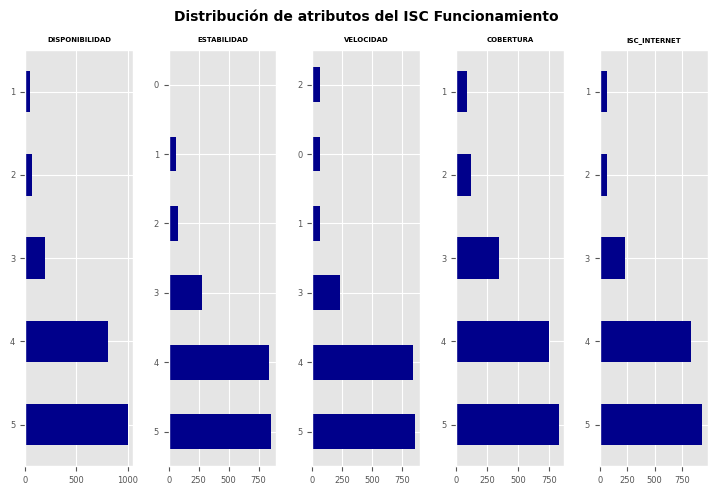

In [10]:
# Gráfico para las variables de atributos del ISC funcionamiento para generar variable objetivo
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10, 5))
axes = axes.flat
columnas_object = ['ISC_INTERNET','DISPONIBILIDAD','ESTABILIDAD','VELOCIDAD','COBERTURA','ISC_INTERNET']

for i, colum in enumerate(columnas_object):
    df_base[colum].value_counts().plot.barh(ax = axes[i], color='darkblue')
    axes[i].set_title(colum, fontsize = 5, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [6, 0]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de atributos del ISC Funcionamiento',
             fontsize = 10, fontweight = "bold");

#### - Variables númericas

In [11]:
# Visualización de 5 primeros registros
# ==============================================================================
display(df_base[numeric_cols].head(5))

,EDAD_CLIENTE,NUMERO_CONEXION,VELOCIDAD_MB,MANZANA,COD_LOTE,AREA_CONSTRUIDA,ALTURA_CONS,VETUSTEZ,ESTRATO,CANTIDAD_EQUIPOS,...,ISC_INTERNET,DISPONIBILIDAD,ESTABILIDAD,VELOCIDAD,COBERTURA,QoS_BRECHA_FISICA,QoS_CANTIDAD_FALLAS,QoS_VELOCIDAD_BAJADA,QoS_DIFERENCIA_ACS,QoS_CALIFICACION_LOGICA
0,16.0,6012649383,100,450948.0,45094806.0,278.40,3.0,1970.0,3,4,...,5,5,4,5,5,2,4,4,4,3
1,21.0,6012572050,100,642311.0,64231105.0,51.09,3.0,2001.0,3,6,...,4,4,4,4,4,3,2,4,4,3
2,21.0,6017643831,100,453716.0,45371601.0,47.80,4.0,1994.0,3,6,...,4,3,3,5,4,4,2,0,2,4
3,21.0,6016263287,500,850239.0,85023901.0,104.00,3.0,1995.0,4,2,...,4,4,4,4,4,2,4,2,2,3
4,21.0,6016970568,80,926724.0,92672417.0,47.67,4.0,1998.0,2,2,...,3,4,3,3,3,3,4,0,4,3


In [12]:
# Visualización de estadísticas descriptivas
# ==============================================================================
df_base[numeric_cols].describe()

,EDAD_CLIENTE,NUMERO_CONEXION,VELOCIDAD_MB,MANZANA,COD_LOTE,AREA_CONSTRUIDA,ALTURA_CONS,VETUSTEZ,ESTRATO,CANTIDAD_EQUIPOS,...,ISC_INTERNET,DISPONIBILIDAD,ESTABILIDAD,VELOCIDAD,COBERTURA,QoS_BRECHA_FISICA,QoS_CANTIDAD_FALLAS,QoS_VELOCIDAD_BAJADA,QoS_DIFERENCIA_ACS,QoS_CALIFICACION_LOGICA
count,1146.000000,2.123000e+03,2123.000000,2.122000e+03,2.120000e+03,2054.000000,2099.000000,2111.000000,2123.000000,2123.000000,...,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000
mean,54.139616,6.014902e+09,225.357984,6.945552e+05,6.716257e+07,132.030944,5.828966,1991.566082,3.471032,3.799812,...,4.186057,4.251060,4.090438,4.021667,3.991521,2.128592,3.222798,1.759303,3.174753,2.488931
std,12.491173,1.941327e+06,115.506462,8.615816e+05,4.300217e+07,115.286653,4.291100,15.992186,1.182453,2.376638,...,0.947119,0.905836,1.013257,1.184848,1.070081,0.923536,1.127502,1.951582,1.042492,0.892552
min,16.000000,6.012002e+09,15.000000,1.108070e+05,1.108072e+07,5.300000,1.000000,1942.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,6.012955e+09,100.000000,5.307438e+05,5.307399e+07,61.492500,3.000000,1980.000000,3.000000,2.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,2.000000,0.000000,2.000000,2.000000
50%,54.000000,6.014532e+09,200.000000,6.405545e+05,6.405520e+07,88.315000,5.000000,1995.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,1.000000,4.000000,2.000000
75%,63.000000,6.016749e+09,300.000000,8.512098e+05,8.512092e+07,166.125000,6.000000,2004.000000,4.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,4.000000,4.000000,4.000000,3.000000
max,104.000000,6.018707e+09,910.000000,2.500000e+07,1.071121e+09,1423.100000,27.000000,2019.000000,6.000000,20.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000


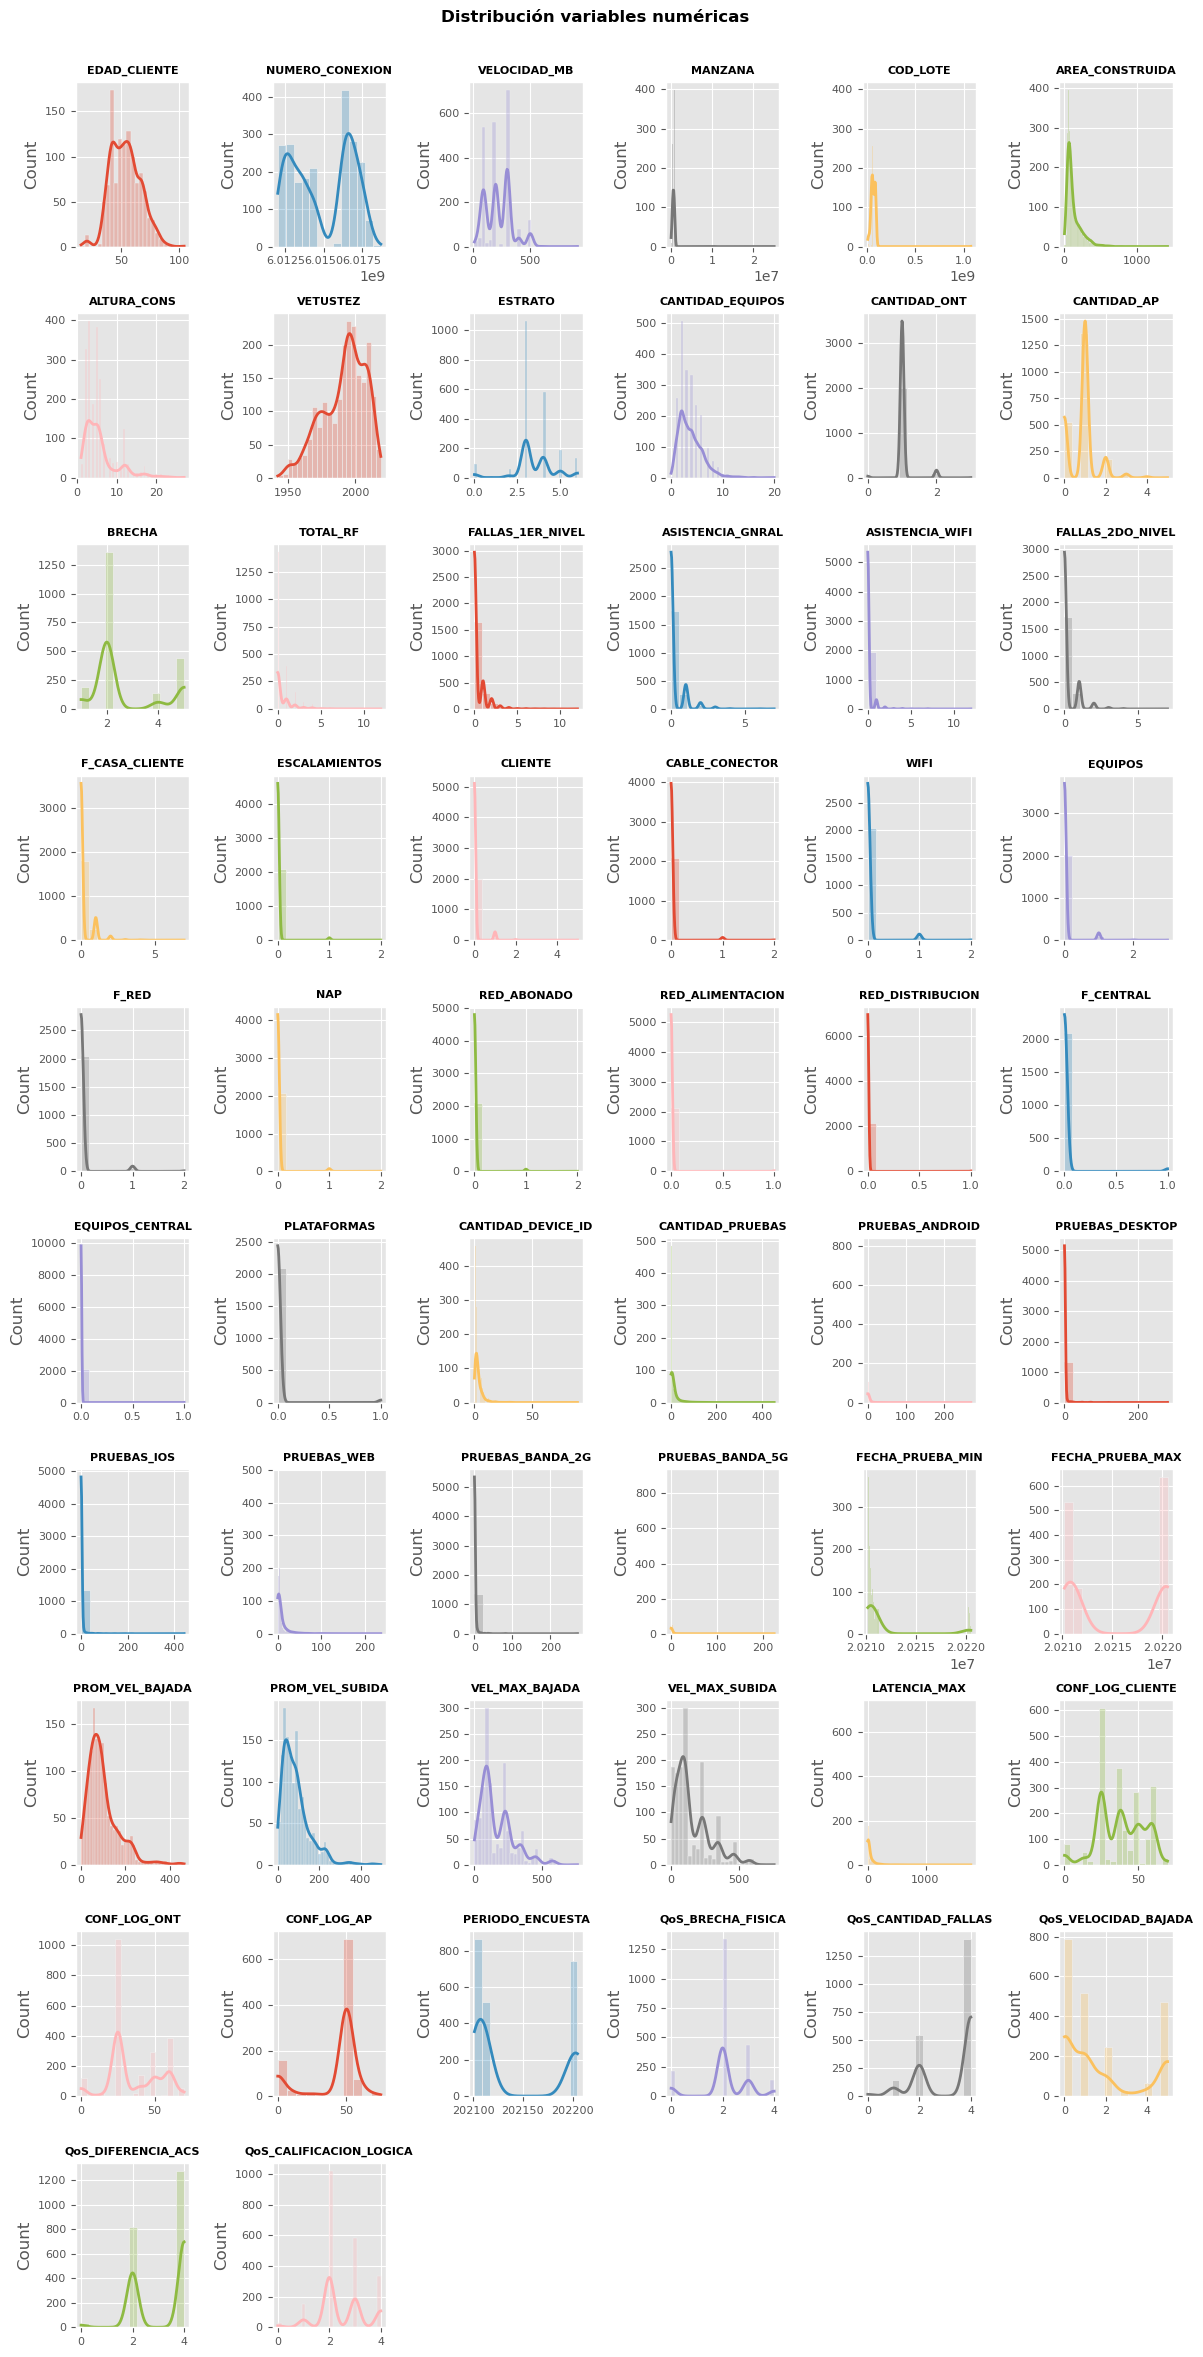

In [13]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 24))
axes = axes.flat
numeric_cols2 = [ 'EDAD_CLIENTE', 'NUMERO_CONEXION', 'VELOCIDAD_MB',
       'MANZANA', 'COD_LOTE', 'AREA_CONSTRUIDA', 'ALTURA_CONS', 'VETUSTEZ',
       'ESTRATO', 'CANTIDAD_EQUIPOS', 'CANTIDAD_ONT', 'CANTIDAD_AP', 'BRECHA',
       'TOTAL_RF', 'FALLAS_1ER_NIVEL', 'ASISTENCIA_GNRAL', 'ASISTENCIA_WIFI',
       'FALLAS_2DO_NIVEL', 'F_CASA_CLIENTE', 'ESCALAMIENTOS', 'CLIENTE',
       'CABLE_CONECTOR', 'WIFI', 'EQUIPOS', 'F_RED', 'NAP', 'RED_ABONADO',
       'RED_ALIMENTACION', 'RED_DISTRIBUCION', 'F_CENTRAL', 'EQUIPOS_CENTRAL',
       'PLATAFORMAS', 'CANTIDAD_DEVICE_ID', 'CANTIDAD_PRUEBAS',
       'PRUEBAS_ANDROID', 'PRUEBAS_DESKTOP', 'PRUEBAS_IOS', 'PRUEBAS_WEB',
       'PRUEBAS_BANDA_2G', 'PRUEBAS_BANDA_5G', 'FECHA_PRUEBA_MIN',
       'FECHA_PRUEBA_MAX', 'PROM_VEL_BAJADA', 'PROM_VEL_SUBIDA',
       'VEL_MAX_BAJADA', 'VEL_MAX_SUBIDA', 'LATENCIA_MAX', 'CONF_LOG_CLIENTE',
       'CONF_LOG_ONT', 'CONF_LOG_AP', 'PERIODO_ENCUESTA',
       'QoS_BRECHA_FISICA', 'QoS_CANTIDAD_FALLAS', 'QoS_VELOCIDAD_BAJADA',
       'QoS_DIFERENCIA_ACS', 'QoS_CALIFICACION_LOGICA']

for i, colum in enumerate(numeric_cols2):
    sns.histplot(
        data    = df_base,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*12)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 8, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")

    
# Se eliminan los axes vacíos
for i in [56,57,58,59]:
    fig.delaxes(axes[i])   
    
fig.tight_layout()
plt.subplots_adjust(top = 0.95)
fig.suptitle('Distribución variables numéricas', fontsize = 12, fontweight = "bold");

Correlación variables numéricas
Se utiliza la función de correlación de las variables, en donde un mejor modelo debe considerar aquellas variables más correlacionadas con la variable a estimar y aquellas variables más decorrelladas entre sí.

In [14]:
display(df_base.corr())

,EDAD_CLIENTE,NUMERO_CONEXION,VELOCIDAD_MB,MANZANA,COD_LOTE,AREA_CONSTRUIDA,ALTURA_CONS,VETUSTEZ,ESTRATO,CANTIDAD_EQUIPOS,...,ISC_INTERNET,DISPONIBILIDAD,ESTABILIDAD,VELOCIDAD,COBERTURA,QoS_BRECHA_FISICA,QoS_CANTIDAD_FALLAS,QoS_VELOCIDAD_BAJADA,QoS_DIFERENCIA_ACS,QoS_CALIFICACION_LOGICA
EDAD_CLIENTE,1.000000,-0.084910,-0.038896,-0.022216,-0.005619,0.011874,-0.044585,-0.158329,0.103804,-0.016513,...,-0.053335,-0.009946,-0.006713,-0.097872,0.031231,-0.021881,-0.011748,-0.073999,0.026222,-0.099815
NUMERO_CONEXION,-0.084910,1.000000,0.054158,0.095851,0.088886,-0.116021,0.086032,0.171385,0.046171,0.105799,...,0.010376,-0.005029,-0.007033,0.016317,-0.015390,0.076272,-0.013111,0.040177,-0.057218,0.069411
VELOCIDAD_MB,-0.038896,0.054158,1.000000,0.076773,0.073295,0.035595,0.060982,0.048615,0.101223,0.027170,...,0.052009,0.048302,0.030144,0.069861,0.027533,0.007807,0.017751,-0.120452,-0.056288,-0.010064
MANZANA,-0.022216,0.095851,0.076773,1.000000,1.000000,-0.049163,0.055864,0.180482,0.037854,0.002077,...,0.016944,0.009858,0.027675,0.024778,0.005033,-0.042194,0.015988,0.031605,-0.056646,0.022462
COD_LOTE,-0.005619,0.088886,0.073295,1.000000,1.000000,-0.049163,0.055864,0.180482,0.233864,0.022103,...,-0.011926,-0.024393,0.007548,0.005583,-0.040251,0.038716,-0.004755,0.029447,-0.053461,0.014467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QoS_BRECHA_FISICA,-0.021881,0.076272,0.007807,-0.042194,0.038716,-0.555089,0.040444,0.135481,0.076558,0.178558,...,-0.007970,-0.033539,0.000156,0.006927,-0.009387,1.000000,0.013204,0.110524,-0.027757,0.191246
QoS_CANTIDAD_FALLAS,-0.011748,-0.013111,0.017751,0.015988,-0.004755,0.017819,0.032037,-0.007956,-0.022197,-0.088162,...,0.062221,0.068865,0.030616,0.014023,0.044531,0.013204,1.000000,-0.070064,0.122019,0.116946
QoS_VELOCIDAD_BAJADA,-0.073999,0.040177,-0.120452,0.031605,0.029447,-0.054583,0.056469,0.044535,0.012395,0.081557,...,0.005118,0.005676,0.014588,0.046074,-0.011358,0.110524,-0.070064,1.000000,0.038520,0.073816
QoS_DIFERENCIA_ACS,0.026222,-0.057218,-0.056288,-0.056646,-0.053461,0.040829,-0.050315,-0.118453,-0.040811,-0.256533,...,-0.006695,-0.000071,0.016260,-0.018328,0.027520,-0.027757,0.122019,0.038520,1.000000,0.228216


In [15]:
# Tabla de correlación entre columnas numéricas
# ==============================================================================
corr_matrix = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(50)

,variable_1,variable_2,r,abs_r
247,COD_LOTE,MANZANA,1.000000,1.000000
187,MANZANA,COD_LOTE,1.000000,1.000000
1920,PLATAFORMAS,F_CENTRAL,0.969678,0.969678
1800,F_CENTRAL,PLATAFORMAS,0.969678,0.969678
2927,CONF_LOG_CLIENTE,QoS_CALIFICACION_LOGICA,0.930981,0.930981
3707,QoS_CALIFICACION_LOGICA,CONF_LOG_CLIENTE,0.930981,0.930981
2729,VEL_MAX_BAJADA,VEL_MAX_SUBIDA,0.923874,0.923874
2789,VEL_MAX_SUBIDA,VEL_MAX_BAJADA,0.923874,0.923874
1055,FALLAS_2DO_NIVEL,F_CASA_CLIENTE,0.910231,0.910231
1115,F_CASA_CLIENTE,FALLAS_2DO_NIVEL,0.910231,0.910231


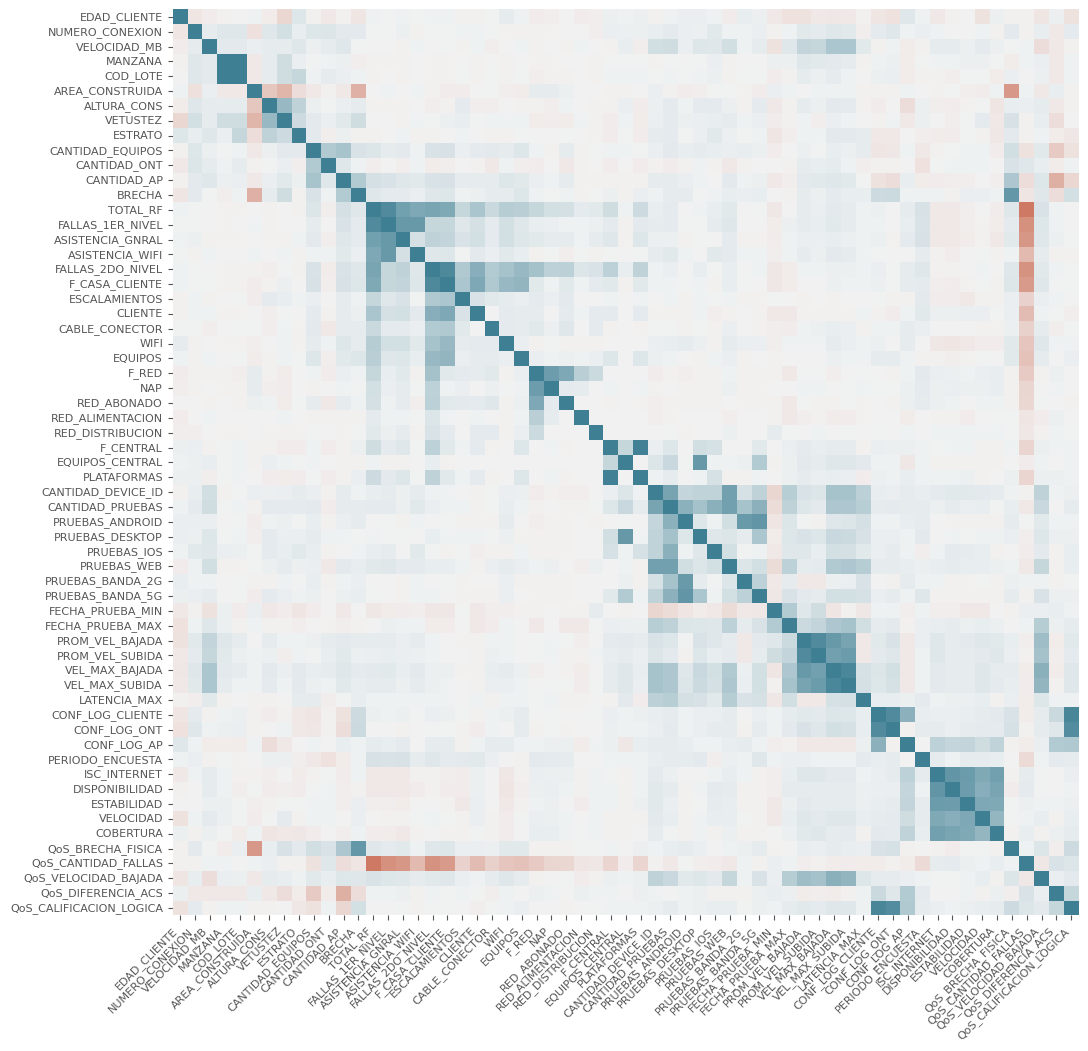

In [16]:
# Visualización de matriz de correlación entre variables
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

sns.heatmap(
    corr_matrix,
    annot     = False,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

**- Variables cualitativas**

In [17]:
# Visualización de 5 primeros registros
# ==============================================================================
display(df_base[cat_cols].head(5))

,TIPO_ID,SEXO_CLIENTE,CIUDAD,DIRECCION,SEGMENTO,CATEGORIA,TECNOLOGIA,CUENTA_SERVICIO,OFERTA,BARRIO,...,MOLECULA,TIPO_NAP,NAP_NEMONICO,MODELO_ONT,MODELO_AP,GRUPO_EQUIPOS,RECOMENDACION_1,RECOMENDACION_2,TIPO_EQ_PREDOM,CONF_LOGICA
0,CC,M,BOGOTA,CL 2 BIS 73B 87,HOGARES,ORO,FTTH,1-EV57292,TRIO,004509-CIUDAD KENNEDY,...,MU04,N1,N1MU04_G12,ONT Nokia Single,AP TPlink C5,1 SINGLE + 0 DUAL + 1 AP,0 SINGLE + 1 DUAL + 2 AP,1 SINGLE + 0 DUAL + 3 AP,Samsung - Galaxy A31,1 SINGLE + 0 DUAL + 1 AP
1,CC,F,BOGOTA,CL 21 88A 79 CA 70,HOGARES,PLATINO,FTTH,1-JK5NOGP,TRIO,006423-EL TINTAL CENTRAL,...,FO04,N2,N2FO04_G21,ONT ZTE Single,AP TPlink C5,1 SINGLE + 0 DUAL + 1 AP,0 SINGLE + 1 DUAL + 0 AP,1 SINGLE + 0 DUAL + 1 AP,NaN,1 SINGLE + 0 DUAL + 1 AP
2,CC,M,BOGOTA,KR 79F 51 43 SUR IN 1 AP 303,HOGARES,ORO,FTTH,CS-410852,TRIO,004537-CASABLANCA,...,HO02,N3,N3HO02_E9,ONT Nokia Dual,AP TPlink C5,0 SINGLE + 1 DUAL + 1 AP,0 SINGLE + 1 DUAL + 0 AP,1 SINGLE + 0 DUAL + 1 AP,NaN,0 SINGLE + 1 DUAL + 0 AP
3,CC,M,BOGOTA,DG 167 12 69 IN 64,HOGARES,PLATINO,FTTH,CS-532561,DUO,008502-LA PRADERA NORTE,...,TO24,N2,N2TO24_F9,ONT Alcatel Single,AP TPlink C5,1 SINGLE + 0 DUAL + 1 AP,0 SINGLE + 1 DUAL + 1 AP,1 SINGLE + 0 DUAL + 2 AP,NaN,1 SINGLE + 0 DUAL + 0 AP
4,CC,F,BOGOTA,KR 112A 137A 45 AP 101,HOGARES,PLATA,FTTH,CS-1165111,DUO,009267-VILLA MARIA I,...,SU21,N1,N1SU21_J23,ONT Alcatel Single,AP TPlink C5,1 SINGLE + 0 DUAL + 1 AP,0 SINGLE + 1 DUAL + 0 AP,1 SINGLE + 0 DUAL + 1 AP,NaN,1 SINGLE + 0 DUAL + 1 AP


In [18]:
# Visualización de estadísticas descriptivas
# ==============================================================================
df_base[cat_cols].describe()

,TIPO_ID,SEXO_CLIENTE,CIUDAD,DIRECCION,SEGMENTO,CATEGORIA,TECNOLOGIA,CUENTA_SERVICIO,OFERTA,BARRIO,...,MOLECULA,TIPO_NAP,NAP_NEMONICO,MODELO_ONT,MODELO_AP,GRUPO_EQUIPOS,RECOMENDACION_1,RECOMENDACION_2,TIPO_EQ_PREDOM,CONF_LOGICA
count,2123,2123,2123,2123,2123,2110,2123,2123,2123,2123,...,2121,2123,2117,2123,2123,2123,2123,2123,291,2092
unique,2,2,2,2122,2,3,1,2123,2,447,...,223,7,2035,5,4,11,5,5,121,17
top,CC,M,BOGOTA,CL 12 SUR 7A 15,HOGARES,PLATINO,FTTH,1-EV57292,DUO,005634-EL CORTIJO,...,CU02,N4,ARMU17_A1,ONT ZTE Single,AP TPlink C5,1 SINGLE + 0 DUAL + 1 AP,0 SINGLE + 1 DUAL + 1 AP,1 SINGLE + 0 DUAL + 2 AP,Samsung - Galaxy A30,1 SINGLE + 0 DUAL + 0 AP
freq,2099,1085,2120,2,1991,1204,2123,1,1240,35,...,30,773,4,937,1103,1154,1439,1439,20,838


In [19]:
cat_cols

Index(['TIPO_ID', 'SEXO_CLIENTE', 'CIUDAD', 'DIRECCION', 'SEGMENTO',
       'CATEGORIA', 'TECNOLOGIA', 'CUENTA_SERVICIO', 'OFERTA', 'BARRIO',
       'CLASE_PREDIO', 'NODO', 'MOLECULA', 'TIPO_NAP', 'NAP_NEMONICO',
       'MODELO_ONT', 'MODELO_AP', 'GRUPO_EQUIPOS', 'RECOMENDACION_1',
       'RECOMENDACION_2', 'TIPO_EQ_PREDOM', 'CONF_LOGICA'],
      dtype='object')

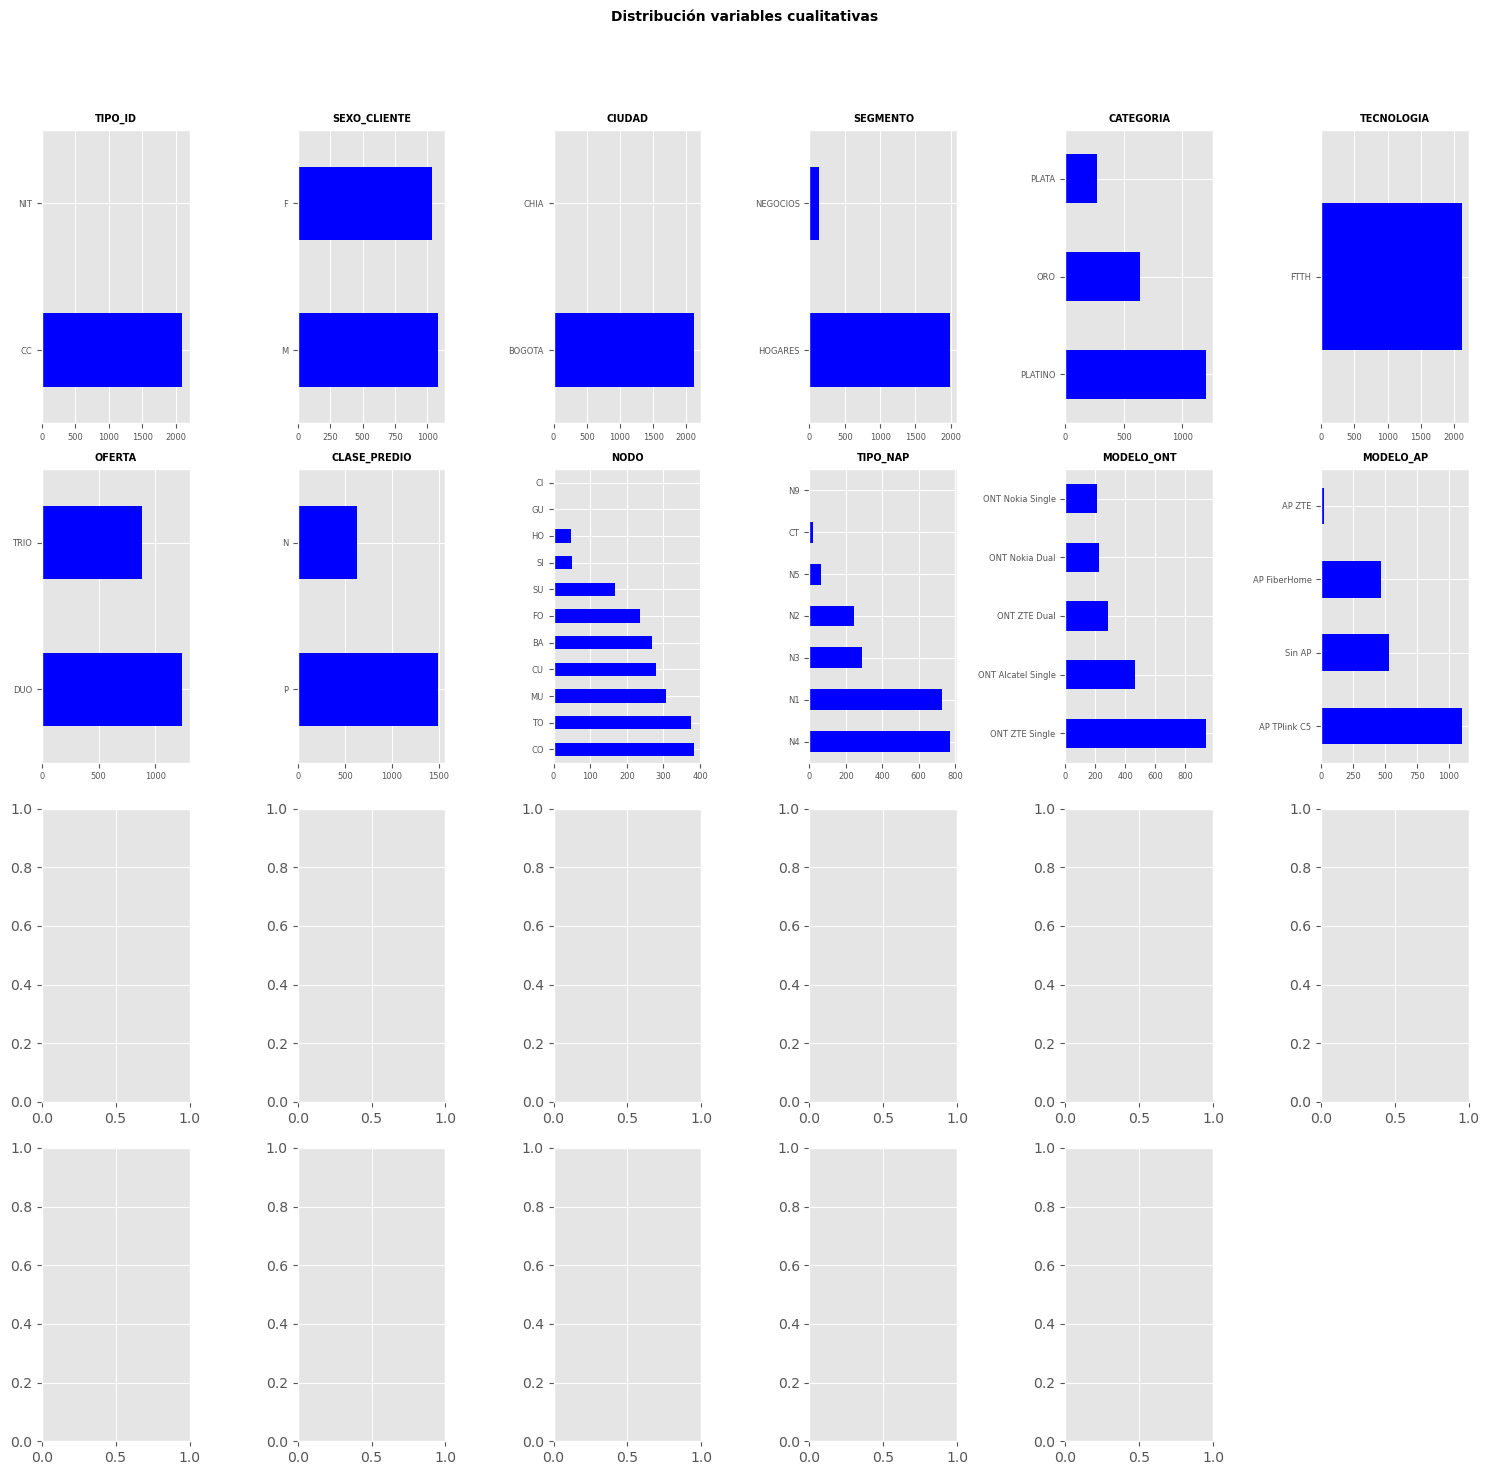

In [20]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 15))
axes = axes.flat

columnas_object = ['TIPO_ID', 'SEXO_CLIENTE', 'CIUDAD','SEGMENTO', 'CATEGORIA', 'TECNOLOGIA',  'OFERTA',
       'CLASE_PREDIO', 'NODO', 'TIPO_NAP','MODELO_ONT', 'MODELO_AP']
        
     #   'DIRECCION', 'CUENTA_SERVICIO','BARRIO',  'MOLECULA','NAP_NEMONICO','GRUPO_EQUIPOS', 
     #   'RECOMENDACION_1', 'RECOMENDACION_2', 'TIPO_EQ_PREDOM',, 'CONF_LOGICA'

for i, colum in enumerate(columnas_object):
    df_base[colum].value_counts().plot.barh(ax = axes[i], color='blue')
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [23]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

# 5.3. Preparación de los datos

#### - Preparación variable categórica (objetivo)

- Creación de variable objetivo (binaria)

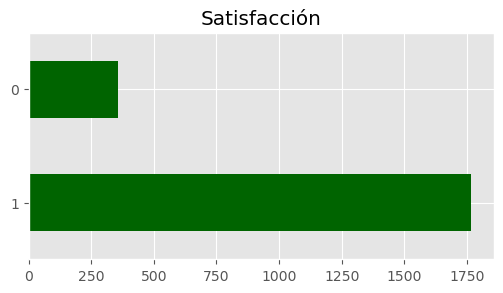

In [21]:
# Se crea columna SATISFECHO, como variable objetivo a partir del promedio de calificación de todos los atributos de funcionamiento del internet ....
# ==============================================================================
df_base['SATISFECHO'] = np.where((df_base['ISC_INTERNET'] > 3.5),1,0)
plt.figure(figsize = (6, 3))
objetivo = df_base['SATISFECHO'].value_counts().plot(kind='barh', color='darkgreen', title='Satisfacción')

- Eliminación de varibales de atributos, dada la creación de la variable objetivo

In [22]:
# Se eliminan columnas cuyo valor se consolida en la variable objetivo SATISFECHO
# ==============================================================================
df_base = df_base.drop(['ISC_INTERNET','DISPONIBILIDAD','ESTABILIDAD','VELOCIDAD','COBERTURA','ISC_INTERNET'], axis=1)

- Se actualiza la clasificación de variables en numéricas y cualitativas

In [23]:
# Se valida el tipo de datos de cada los atributos cargados(columnas) que componen el archivo fuente cargado en dataframe en python
# En pandas, el tipo "object" hace referencia a strings
# Clasificación de variables categóricas y numéricas
# ==============================================================================
cat_cols = df_base.select_dtypes(include=['object','category']).columns
numeric_cols = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).columns
len(cat_cols),len(numeric_cols)

(22, 57)

#### - Variables númericas

In [24]:
### Análisis de varibles numericas

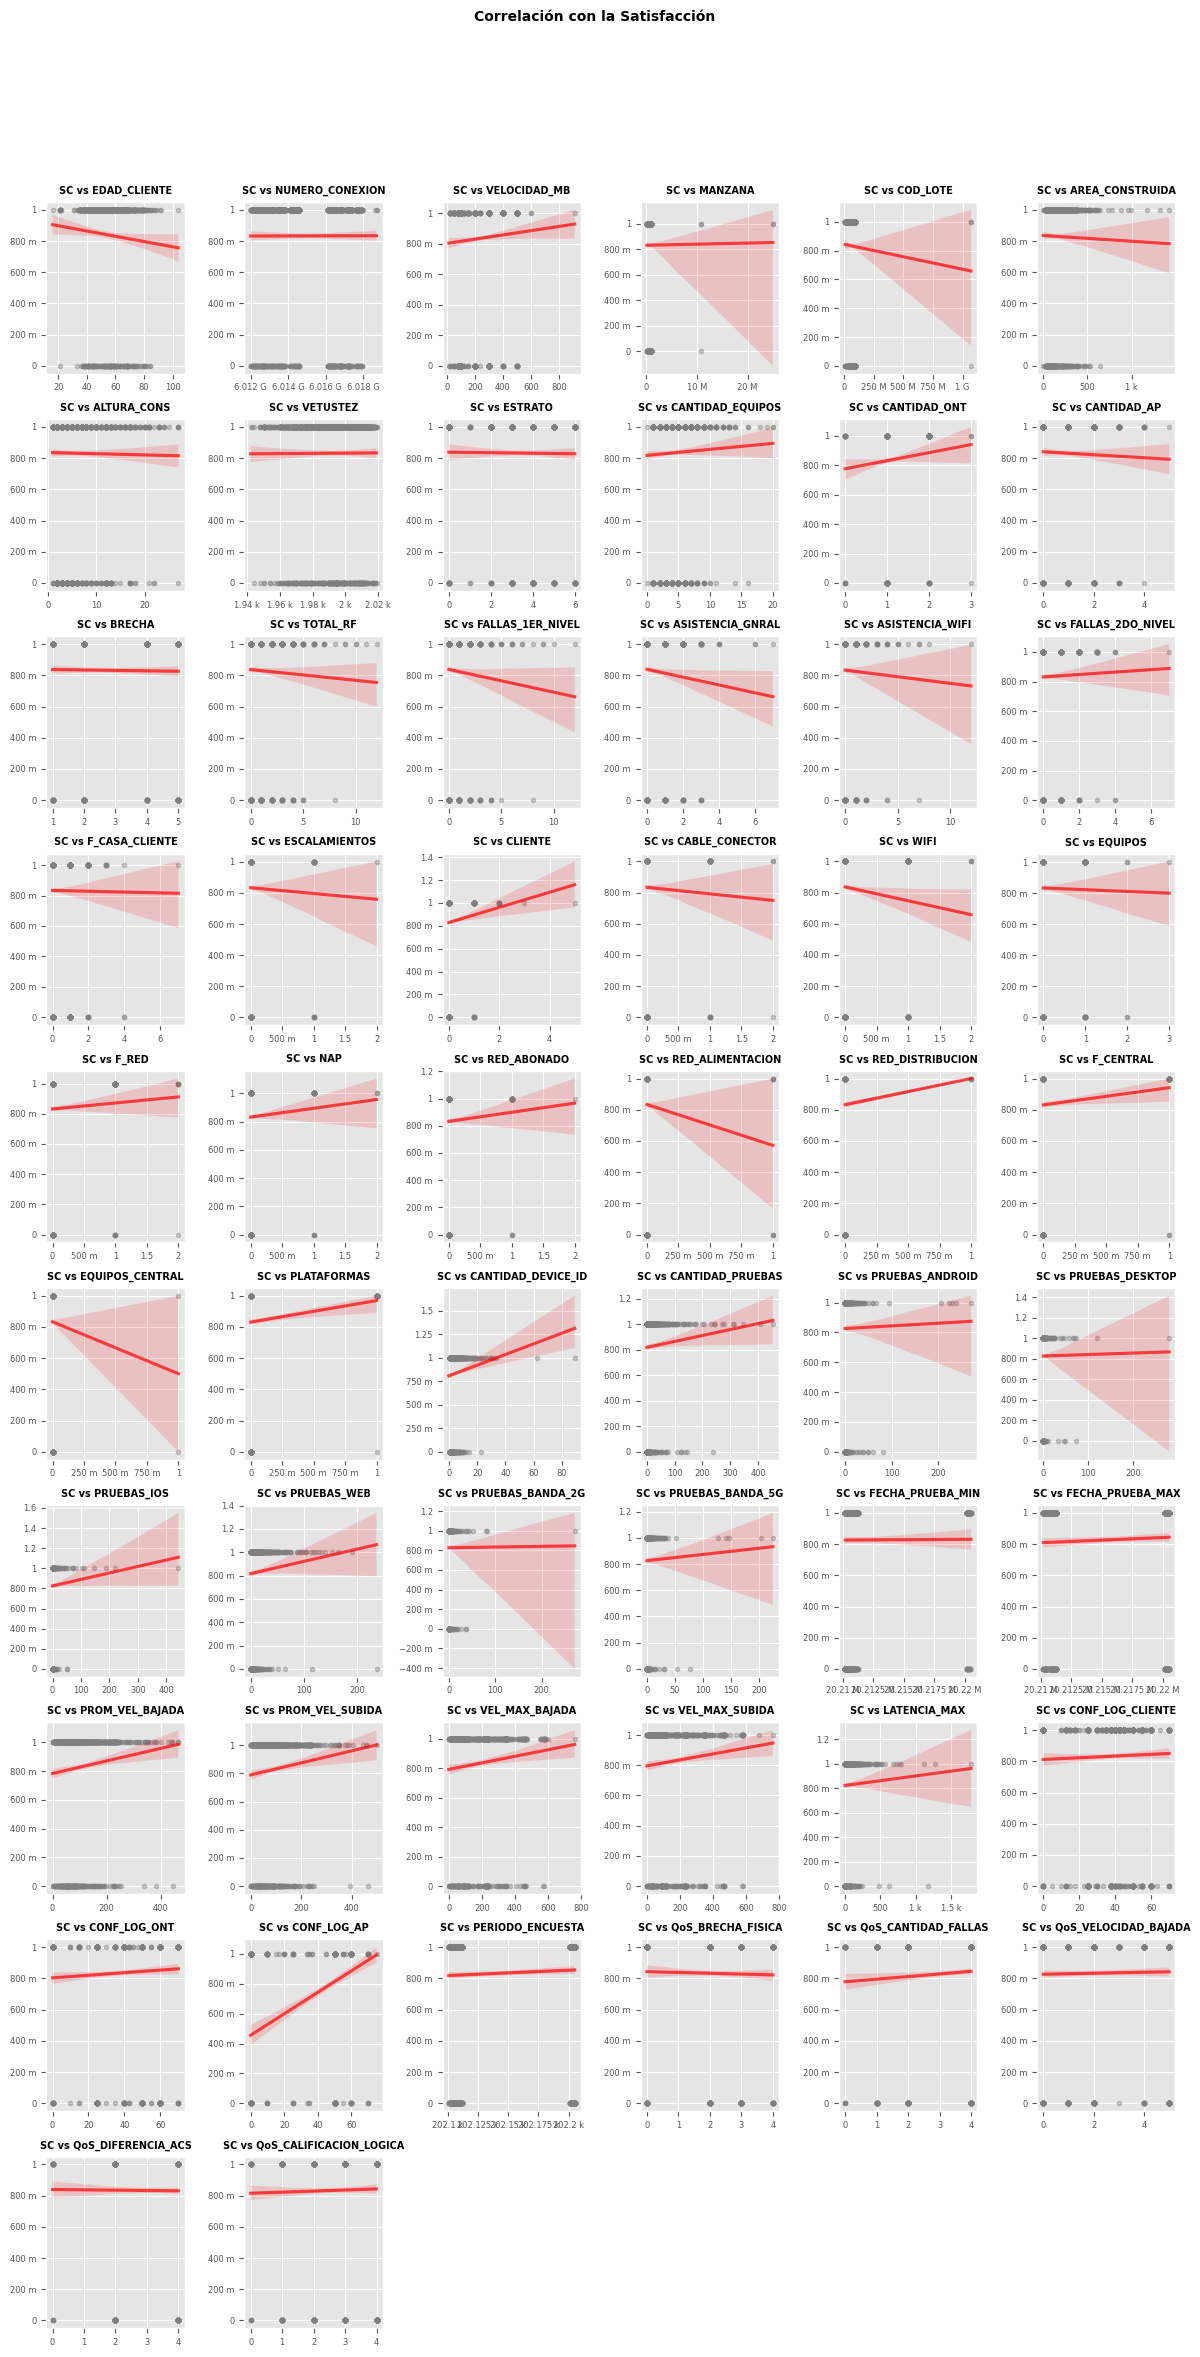

In [25]:
# Gráfico de distribución para cada variable numérica en relación a la variable respuesta 'SATISFECHO'. 
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 24))
axes = axes.flat

numeric_cols2 = [ 'EDAD_CLIENTE', 'NUMERO_CONEXION', 'VELOCIDAD_MB',
       'MANZANA', 'COD_LOTE', 'AREA_CONSTRUIDA', 'ALTURA_CONS', 'VETUSTEZ',
       'ESTRATO', 'CANTIDAD_EQUIPOS', 'CANTIDAD_ONT', 'CANTIDAD_AP', 'BRECHA',
       'TOTAL_RF', 'FALLAS_1ER_NIVEL', 'ASISTENCIA_GNRAL', 'ASISTENCIA_WIFI',
       'FALLAS_2DO_NIVEL', 'F_CASA_CLIENTE', 'ESCALAMIENTOS', 'CLIENTE',
       'CABLE_CONECTOR', 'WIFI', 'EQUIPOS', 'F_RED', 'NAP', 'RED_ABONADO',
       'RED_ALIMENTACION', 'RED_DISTRIBUCION', 'F_CENTRAL', 'EQUIPOS_CENTRAL',
       'PLATAFORMAS', 'CANTIDAD_DEVICE_ID', 'CANTIDAD_PRUEBAS',
       'PRUEBAS_ANDROID', 'PRUEBAS_DESKTOP', 'PRUEBAS_IOS', 'PRUEBAS_WEB',
       'PRUEBAS_BANDA_2G', 'PRUEBAS_BANDA_5G', 'FECHA_PRUEBA_MIN',
       'FECHA_PRUEBA_MAX', 'PROM_VEL_BAJADA', 'PROM_VEL_SUBIDA',
       'VEL_MAX_BAJADA', 'VEL_MAX_SUBIDA', 'LATENCIA_MAX', 'CONF_LOG_CLIENTE',
       'CONF_LOG_ONT', 'CONF_LOG_AP', 'PERIODO_ENCUESTA',
       'QoS_BRECHA_FISICA', 'QoS_CANTIDAD_FALLAS', 'QoS_VELOCIDAD_BAJADA',
       'QoS_DIFERENCIA_ACS', 'QoS_CALIFICACION_LOGICA']

#numeric_cols.drop('SATISFECHO')

for i, colum in enumerate(numeric_cols2):
    sns.regplot(
        x           = df_base[colum],
        y           = df_base['SATISFECHO'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"SC vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [56,57,58,59]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con la Satisfacción', fontsize = 10, fontweight = "bold");

- A continuación el detalle de las acciones a adelantar con cada una de las variables numericas y su tratamiento como insumo para los modelos de la comparativa

|   Variable   |   Aspecto evaluado (describe)   |   Descripción   |   Valores de decisión   |   Tratamiento   |
|:-|:-|:-|:-|:-|
| EDAD_CLIENTE | count | Es representativa en la clasificación | 99% | **Mantener** variable |

In [26]:
# Eliminación de variable númericas del set de datos, resultante del análisis
# ==============================================================================

df_base = df_base.drop(['NUMERO_CONEXION','COD_LOTE'], axis=1)
df_base = df_base.drop(['FECHA_PRUEBA_MIN','FECHA_PRUEBA_MAX','PROM_VEL_SUBIDA','VEL_MAX_BAJADA','VEL_MAX_SUBIDA'], axis=1)
df_base = df_base.drop(['TOTAL_RF','FALLAS_1ER_NIVEL','FALLAS_2DO_NIVEL','F_RED','F_CENTRAL'], axis=1)# son totalizadores
df_base = df_base.drop(['CONF_LOG_CLIENTE','CANTIDAD_PRUEBAS','PERIODO_ENCUESTA','CANTIDAD_DEVICE_ID'], axis=1)# información complementaria

- Se actualiza la clasificación de variables en numéricas y cualitativas

In [27]:
# Se valida el tipo de datos de cada los atributos cargados(columnas) que componen el archivo fuente cargado en dataframe en python
# En pandas, el tipo "object" hace referencia a strings
# Clasificación de variables categóricas y numéricas
# ==============================================================================
cat_cols = df_base.select_dtypes(include=['object','category']).columns
numeric_cols = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).columns
len(cat_cols),len(numeric_cols)

(22, 41)

- Verificación de correlacion luego de ajustes

In [28]:
# Correlación entre columnas numéricas
# ==============================================================================
corr_matrix = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(50)

,variable_1,variable_2,r,abs_r
1632,QoS_CALIFICACION_LOGICA,CONF_LOG_ONT,0.876283,0.876283
1392,CONF_LOG_ONT,QoS_CALIFICACION_LOGICA,0.876283,0.876283
1255,PRUEBAS_BANDA_5G,PRUEBAS_ANDROID,0.795425,0.795425
1055,PRUEBAS_ANDROID,PRUEBAS_BANDA_5G,0.795425,0.795425
445,BRECHA,QoS_BRECHA_FISICA,0.775687,0.775687
1445,QoS_BRECHA_FISICA,BRECHA,0.775687,0.775687
1089,PRUEBAS_DESKTOP,EQUIPOS_CENTRAL,0.769435,0.769435
969,EQUIPOS_CENTRAL,PRUEBAS_DESKTOP,0.769435,0.769435
1054,PRUEBAS_ANDROID,PRUEBAS_BANDA_2G,0.756462,0.756462
1214,PRUEBAS_BANDA_2G,PRUEBAS_ANDROID,0.756462,0.756462


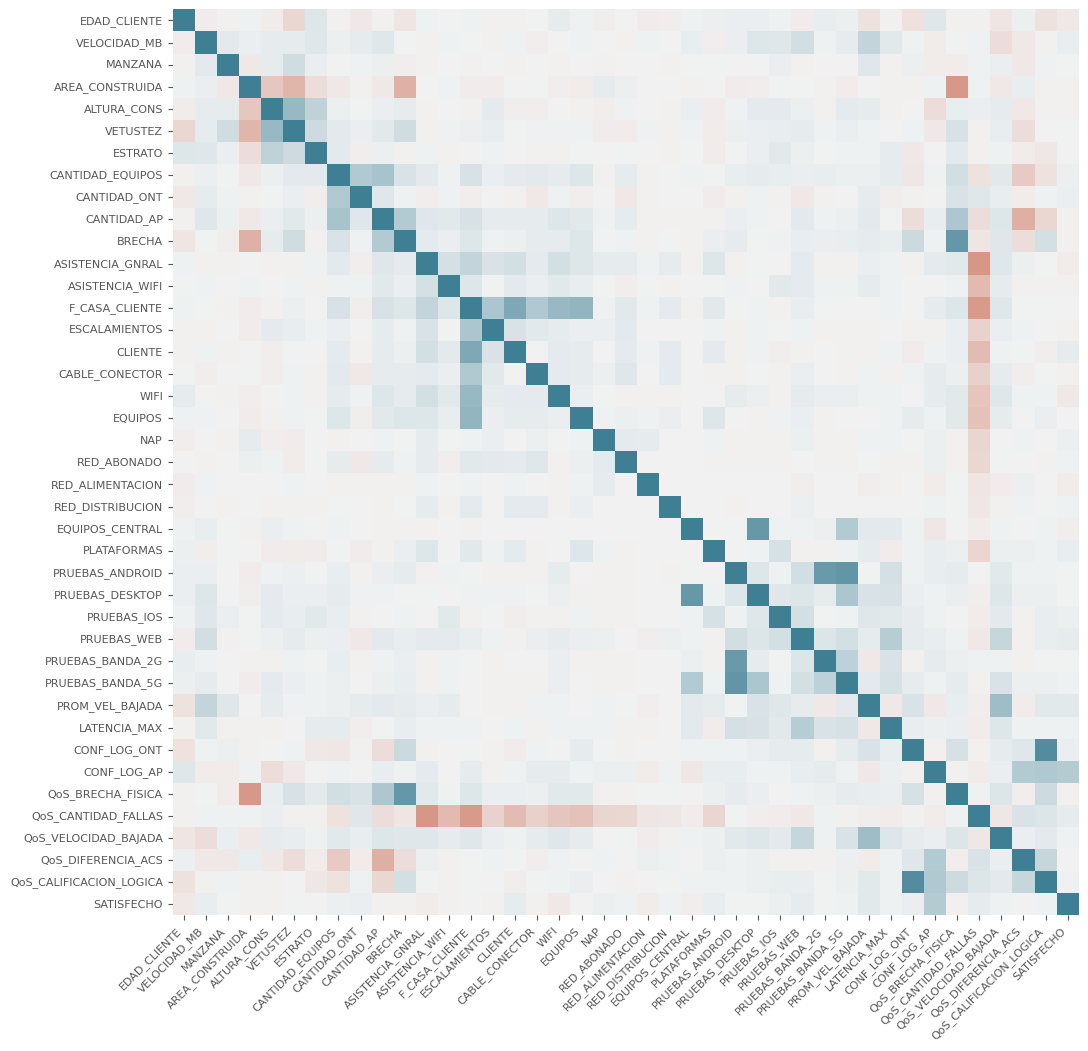

In [29]:
# Visualización de matriz de correlación entre variables luego de ajuste
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

sns.heatmap(
    corr_matrix,
    annot     = False,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

**- Variables cualitativas**

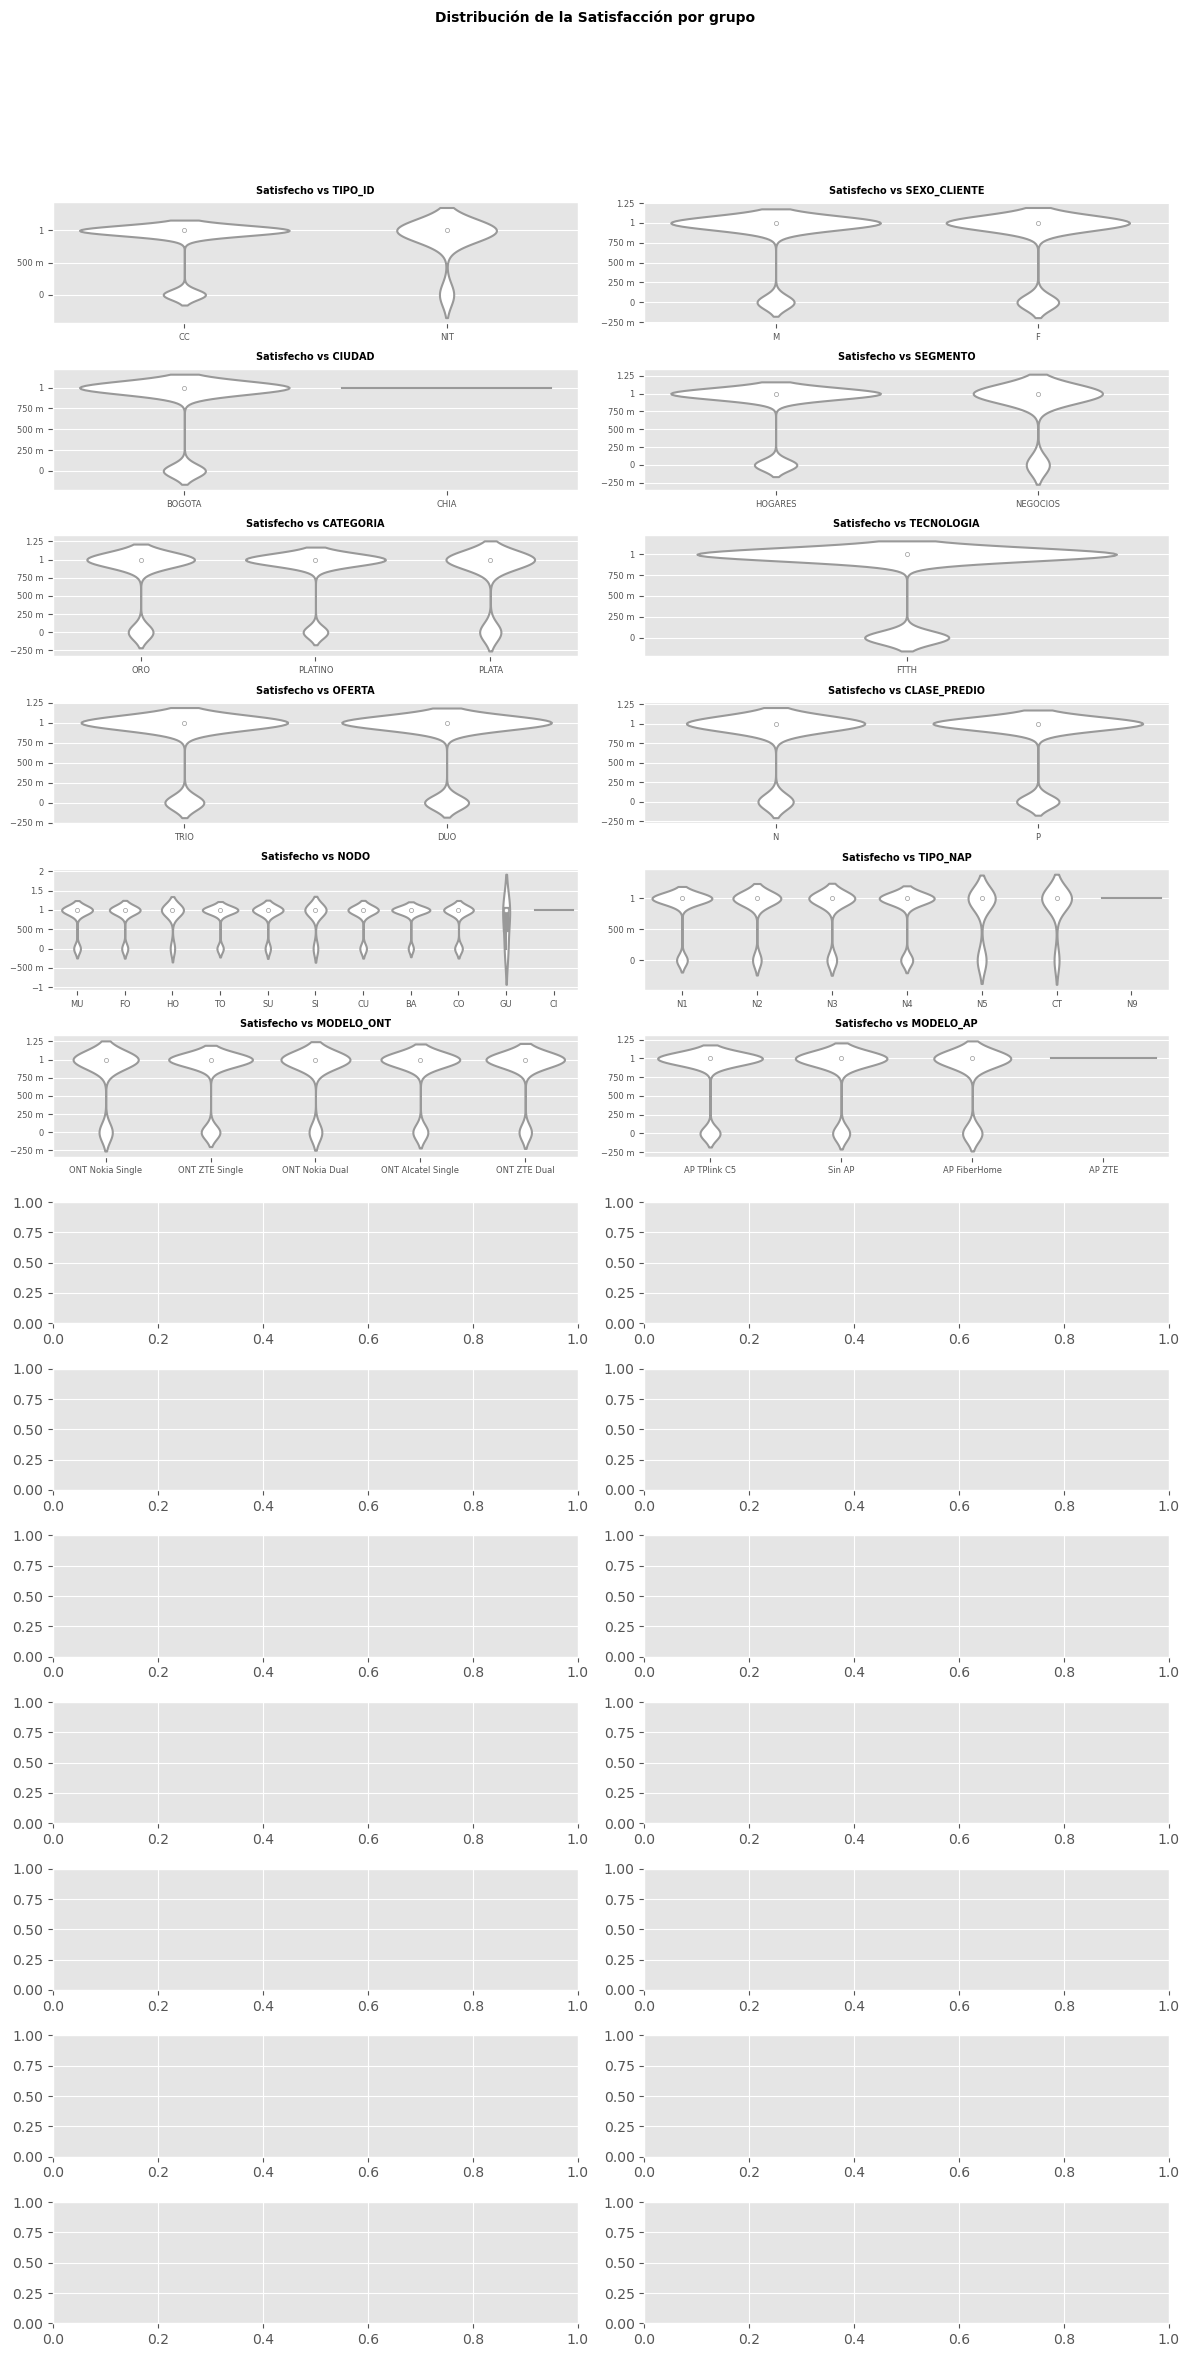

In [30]:
# Gráfico relación entre la Satisfacción y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(12, 24))
axes = axes.flat
columnas_object = ['TIPO_ID', 'SEXO_CLIENTE', 'CIUDAD','SEGMENTO', 'CATEGORIA', 'TECNOLOGIA',  'OFERTA',
       'CLASE_PREDIO', 'NODO', 'TIPO_NAP','MODELO_ONT', 'MODELO_AP']

#cat_cols

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'SATISFECHO',
        data  = df_base,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"Satisfecho vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in []:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de la Satisfacción por grupo', fontsize = 10, fontweight = "bold");

In [31]:
# Visualización de estadísticas descriptivas
# ==============================================================================
df_base[cat_cols].describe()

,TIPO_ID,SEXO_CLIENTE,CIUDAD,DIRECCION,SEGMENTO,CATEGORIA,TECNOLOGIA,CUENTA_SERVICIO,OFERTA,BARRIO,...,MOLECULA,TIPO_NAP,NAP_NEMONICO,MODELO_ONT,MODELO_AP,GRUPO_EQUIPOS,RECOMENDACION_1,RECOMENDACION_2,TIPO_EQ_PREDOM,CONF_LOGICA
count,2123,2123,2123,2123,2123,2110,2123,2123,2123,2123,...,2121,2123,2117,2123,2123,2123,2123,2123,291,2092
unique,2,2,2,2122,2,3,1,2123,2,447,...,223,7,2035,5,4,11,5,5,121,17
top,CC,M,BOGOTA,CL 12 SUR 7A 15,HOGARES,PLATINO,FTTH,1-EV57292,DUO,005634-EL CORTIJO,...,CU02,N4,ARMU17_A1,ONT ZTE Single,AP TPlink C5,1 SINGLE + 0 DUAL + 1 AP,0 SINGLE + 1 DUAL + 1 AP,1 SINGLE + 0 DUAL + 2 AP,Samsung - Galaxy A30,1 SINGLE + 0 DUAL + 0 AP
freq,2099,1085,2120,2,1991,1204,2123,1,1240,35,...,30,773,4,937,1103,1154,1439,1439,20,838


### Análisis de varibles cualitativas

- A continuación el detalle de las acciones a adelantar con cada una de las variables cualitativas y su tratamiento como insumo para los modelos de la comparativa

|   Variable   |   Aspecto evaluado (describe)   |   Descripción   |   Valores de decisión   |   Tratamiento   |
|:-|:-|:-|:-|:-|
| TIPO_ID | freg | No es representativa en la clasificación | 99% son de un mismo tipo | **Eliminar** variable |
| SEXO_CLIENTE | unique | Al tener una distribución homogenea entre hombre y mujeres no es relevante  | 51% | **Eliminar** variable |
| CIUDAD | freg | No es representativa en la clasificación | 100% de una ciudad | **Eliminar** variable |
| DIRECCION | unique | No es representativa en la clasificación | Son ubicaciones unicas | **Eliminar** variable |
| SEGMENTO | freq | No es representativa en la clasificación | 94% de un mismo segmento| **Eliminar** variable |
| CATEGORIA | freq | No es representativa en la clasificación | 94% de una misma categoria | **Eliminar** variable |
| TECNOLOGIA | freq | No es representativa en la clasificación | 100% de la tecnología FTTH | **Eliminar** variable |
| CUENTA_SERVICIO | unique | No es representativa en la clasificación | Identificador unico, no se repite | **Eliminar** variable |
| OFERTA | unique | No es relevante para la predicción del funcionamiento del servicio de internet, dado que para todas las ofertas es requerida la conectividad | 58% | **Eliminar** variable |
| BARRIO | unique | Número considerable de valores | 21% | **Eliminar** variable |
| CLASE_PREDIO | unique | Al existir dos valores, siendo el representativo el P (Propiedad Horizontal 'conjunto') | 67% |**Reemplazar**: crear variable 'PREDIO_PH' donde nos indica en forma de números que uno es para Propiedad Horizontal 'conjunto' y cero para No Propiedad Horizontal 'casas', a partir de los valores de la columna 'CLASE_PREDIO' antes de su eliminación |
| NODO | unique | No es representativa en la clasificación | Es la agrupación de moleculas, poligono de cobertura muy amplio | **Eliminar** variable |
| MOLECULA | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| TIPO_NAP | unique | El tipo de NAP va directamente relacionado con CLASE_PREDIO  | 100% | **Eliminar** variable |
| NAP | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| MODELO_ONT | unique | Al referenciar caracteristicas de un equipo instalado, es una variable relevante para el funcionamiento | 100% | **Reemplazar**: crear variables 'ONT_ZTE_SINGLE', 'ONT_ALC_SINGLE', 'ONT_NOKIA_SINGLE', 'ONT_ZTE_DUAL', y 'ONT_NOKIA_DUAL', donde dependiendo del tipo de ONT se poblara la columna correspondiente con valor 1 y las demás con valor 0, a partir de los valores de la columna 'MODELO_ONT' antes de su eliminación |
| MODELO_AP | unique | Al referenciar caracteristicas de un equipo instalado, es una variable relevante para el funcionamiento | 100% | **Reemplazar**: crear variables 'AP_TPLINK', 'AP_FIBERHOME', 'AP_ZTE' y 'AP_SIN_AP', donde dependiendo del tipo de AP se poblara la columna correspondiente con valor 1 y las demás con valor 0, a partir de los valores de la columna 'MODELO_AP' antes de su eliminación |
| GRUPO_EQUIPOS | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| RECOMENDACION_1 | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| RECOMENDACION_2 | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| RESULTADO_BRECHA | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| TIPO_EQ_PREDOM | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |
| CONF_LOG | unique | No es representativa en la clasificación | 100% | **Eliminar** variable |


In [32]:
# Creación de variables
# ==============================================================================
# Creación de variable a partir de CLASE_PREDIO
df_base['PREDIO_PH'] = np.where((df_base['CLASE_PREDIO'] == 'P'),1,0)

# Creación de variables a partir de MODELO_ONT
df_base['ONT_ZTE_SINGLE'] = np.where((df_base['MODELO_ONT'] == 'ONT ZTE Single'),1,0)
df_base['ONT_ALC_SINGLE'] = np.where((df_base['MODELO_ONT'] == 'ONT Alcatel Single'),1,0)
df_base['ONT_NOKIA_SINGLE'] = np.where((df_base['MODELO_ONT'] == 'ONT Nokia Single'),1,0)
df_base['ONT_ZTE_DUAL'] = np.where((df_base['MODELO_ONT'] == 'ONT ZTE Dual'),1,0)
df_base['ONT_NOKIA_DUAL'] = np.where((df_base['MODELO_ONT'] == 'ONT Nokia Dual'),1,0)

# Creación de variables a partir de MODELO_AP
df_base['AP_TPLINK'] = np.where((df_base['MODELO_AP'] == 'AP TPlink C5'),1,0)
df_base['AP_FIBERHOME'] = np.where((df_base['MODELO_AP'] == 'AP FiberHome'),1,0)
df_base['AP_ZTE'] = np.where((df_base['MODELO_AP'] == 'AP ZTE'),1,0)
df_base['AP_SIN_AP'] = np.where((df_base['MODELO_AP'] == 'Sin AP' ),1,0)

In [33]:
# Eliminación de variables por reemplazo
# ==============================================================================
df_base = df_base.drop(['CLASE_PREDIO','MODELO_ONT','MODELO_AP'], axis=1)

In [34]:
# Eliminación de variable cualitativas del set de datos, resultante del análisis
# ==============================================================================
df_base = df_base.drop(['SEXO_CLIENTE','OFERTA','TIPO_NAP'], axis=1)
df_base = df_base.drop(['TIPO_ID','CIUDAD','DIRECCION','SEGMENTO','CATEGORIA','TECNOLOGIA','CUENTA_SERVICIO'], axis=1)
df_base = df_base.drop(['BARRIO','NODO','MOLECULA','NAP_NEMONICO','GRUPO_EQUIPOS','RECOMENDACION_1'], axis=1)
df_base = df_base.drop(['RECOMENDACION_2','BRECHA','TIPO_EQ_PREDOM','CONF_LOGICA'], axis=1)

**-Tratamiento de missing**

Antes de realizar cualquier evaluación sobre los datos es importante siempre realizar un tratamiento previo con el fin de abordar el problema de los datos faltantes. Se citan algunos ejemplos: 
1. Si la cantidad de datos faltantes es muy grande se recomienda borrar estas variables.
2. Si existe una cantidad pequeña de filas con datos faltantes en sus variables se puede optar por borrarlas.
2.  Para variables categóricas se puede agregar un estado adicional que describa este factor.
4. Se puede llenar los datos faltantes con la media, mediana o moda de la variable tanto para variables numéricas o categóricas.
5. Para variables categóricas, se puede optar por una asignación aleatoria de categorías escogido aquellas que se encuentren presentes en esa variable, tratado de buscar que se encuentren uniformemente distribuidas.
6. En ocasiones no existen valores faltantes o nulos, existen valores en cero que realmente están reflejando datos faltantes.

- Se obtiene las columnas que tienen datos faltantes.

In [35]:
# Visualización de conteo de variables con valores nulos
# ==============================================================================
col_total_nulos = df_base.isnull().sum()
serie_col_nombres = col_total_nulos[col_total_nulos > 0]
display(serie_col_nombres)

EDAD_CLIENTE         977
MANZANA                1
AREA_CONSTRUIDA       69
ALTURA_CONS           24
VETUSTEZ              12
PRUEBAS_ANDROID      768
PRUEBAS_DESKTOP      768
PRUEBAS_IOS          768
PRUEBAS_WEB          768
PRUEBAS_BANDA_2G     768
PRUEBAS_BANDA_5G     768
PROM_VEL_BAJADA      768
LATENCIA_MAX         768
CONF_LOG_ONT          43
CONF_LOG_AP         1126
dtype: int64

Se visualizan 15 variable que contienen valores nulos

- Revisar valores en cero

Si observamos el resultado de las estadisticas del análisis exploratorio de los datos, podemos ver que hay muchas columnas con valor mínimo en cero. Sin embargo para el contexto evaluado, son validos. Las columnas no deben tener valor en cero son:

* Velocidad MB
* Area Construida
* Cantidad de equipos
* Cantidad de ONT

Si vemos las 20 primeras filas del análisis exploratorio de los datos, podemos ver ceros en la columna 3, 4 y 5. Contemos ahora los ceros que existen en cada columna del dataset.

- Sumemos los ceros por columna

In [36]:
# Visualización de conteo de variables con valores cero
# ==============================================================================
(df_base==0).sum(axis=0)

EDAD_CLIENTE                  0
VELOCIDAD_MB                  0
MANZANA                       0
AREA_CONSTRUIDA               0
ALTURA_CONS                   0
VETUSTEZ                      0
ESTRATO                      91
CANTIDAD_EQUIPOS              2
CANTIDAD_ONT                 20
CANTIDAD_AP                 529
ASISTENCIA_GNRAL           1747
ASISTENCIA_WIFI            1956
F_CASA_CLIENTE             1802
ESCALAMIENTOS              2090
CLIENTE                    2006
CABLE_CONECTOR             2084
WIFI                       2041
EQUIPOS                    2023
NAP                        2085
RED_ABONADO                2093
RED_ALIMENTACION           2116
RED_DISTRIBUCION           2119
EQUIPOS_CENTRAL            2121
PLATAFORMAS                2091
PRUEBAS_ANDROID             803
PRUEBAS_DESKTOP            1230
PRUEBAS_IOS                1169
PRUEBAS_WEB                 206
PRUEBAS_BANDA_2G           1108
PRUEBAS_BANDA_5G            893
PROM_VEL_BAJADA               2
LATENCIA

Podemos ver que 38 de 44 variables (columnas) que contienen valores en cero. Sin embargo, en este set de datos y para estas columnas el valor cero es validoy no se pueden considerar como valores faltantes.

### Preparación de los set de datos para la camparativa

**- Manejo de valores faltantes**

En Python, específicamente con Pandas, NumPy y Scikit-Learn, se marcan los valores faltantes como NaN.

In [37]:
# Visualización de conteo de variables con valores nulos
# ==============================================================================
col_total_nulos = df_base.isnull().sum()
serie_col_nombres = col_total_nulos[col_total_nulos > 0]
display(serie_col_nombres)

EDAD_CLIENTE         977
MANZANA                1
AREA_CONSTRUIDA       69
ALTURA_CONS           24
VETUSTEZ              12
PRUEBAS_ANDROID      768
PRUEBAS_DESKTOP      768
PRUEBAS_IOS          768
PRUEBAS_WEB          768
PRUEBAS_BANDA_2G     768
PRUEBAS_BANDA_5G     768
PROM_VEL_BAJADA      768
LATENCIA_MAX         768
CONF_LOG_ONT          43
CONF_LOG_AP         1126
dtype: int64

Podemos ver que 14 variables contienen valores nulos

In [38]:
# Actualización de variables númericas y categóricas para este set de datos
# ==============================================================================
cat_cols = df_base.select_dtypes(include=['object','category']).columns
numeric_cols = df_base.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).columns
print("Las variables categoricas y numericas son:",len(cat_cols),"y",len(numeric_cols))

Las variables categoricas y numericas son: 0 y 50


- Se genera set de datos eliminando las filas donde se tiene valores nulos

### Primer set de datos para la comparativa

La estrategia más sencilla para manejar los datos faltantes es eliminar los registros que contienen un valor perdido.

Podemos hacer esto creando un nuevo Pandas DataFrame con las filas que contienen los valores faltantes

Pandas proporciona la función dropna () que se puede utilizar para eliminar columnas o filas con datos faltantes. Podemos usar dropna () para eliminar todas las filas con datos faltantes, de la siguiente manera:

In [39]:
df_base_missing_dropn=df_base.copy()
# Revisar cuántas filas y columnas tiene df_base_missing_dropn
print(df_base_missing_dropn.shape)
# Borrar filas con datos faltantes
df_base_missing_dropn.dropna(inplace=True)
# Ahora cuántas filas hay
df_base_missing_dropn.shape

(2123, 50)


(387, 50)

- Se genera set de datos eliminando columnas con un % de valores faltantes

### Segundo set de datos para la comparativa

Ahora eliminemos aquellas columnas que tienen un % de nulos mayor a un parámetro definido previamente.

In [40]:
df_base_missing_dropnColumns=df_base.copy()
# Revisar cuántas filas y columnas tiene df_base_missing_dropn
print(df_base_missing_dropnColumns.shape)
# Borrar filas con datos faltantes
perc = 25.0 # mayor al 50% de valores faltantes
min_count =  int(((100-perc)/100)*df_base_missing_dropnColumns.shape[0] + 1)
df_base_missing_dropnColumns = df_base_missing_dropnColumns.dropna( axis=1, 
                    thresh=min_count)
# Ahora cuántas columnas hay
df_base_missing_dropnColumns.shape


(2123, 50)


(2123, 40)

In [41]:
# Actualización de variables númericas y categóricas para este set de datos
# ==============================================================================
cat_cols_missingColumns = df_base_missing_dropnColumns.select_dtypes(include=['object','category']).columns
numeric_cols_missingColumns = df_base_missing_dropnColumns.select_dtypes(include=['float64', 'float32', 'float', 'int64','int32', 'int']).columns
print("Las variables categoricas y numericas son:",len(cat_cols_missingColumns),"y",len(numeric_cols_missingColumns))

Las variables categoricas y numericas son: 0 y 40


Después de eliminar columnas, reemplazar valores NaN con la media

In [42]:
df_base_missing_dropnColumns=df_base_missing_dropnColumns.fillna(df_base_missing_dropnColumns.mean())
display('Verificación de datos faltantes : {0}'.format(df_base_missing_dropnColumns.isnull().sum().max()))

'Verificación de datos faltantes : 0'

- Se genera set de datos reemplazando valores faltantes con la media

### Tercer set de datos para la comparativa

In [43]:
df_base_missing_mean=df_base.copy()
df_base_missing_mean=df_base_missing_mean.fillna(df_base_missing_mean.mean())
display('Verificación de datos faltantes : {0}'.format(df_base_missing_mean.isnull().sum().max()))

'Verificación de datos faltantes : 0'

In [44]:
df_base_missing_mean.shape

(2123, 50)

- Se genera set de datos reemplazando valores faltantes con la moda

### Cuarto set de datos para la comparativa

- Se genera set de datos reemplazando valores faltantes con una función de interpolación, usando método lineal

In [45]:
df_base_missing_interpo=df_base.copy()
display('Verificación de datos faltantes : {0}'.format(df_base_missing_interpo.isnull().sum().max()))

df_base_missing_interpo=df_base_missing_interpo.interpolate(method ='linear', limit_direction ='forward')
display('Verificación de datos faltantes : {0}'.format(df_base_missing_interpo.isnull().sum().max()))

'Verificación de datos faltantes : 1126'

'Verificación de datos faltantes : 0'

# 5.4. Modelado

### - Modelado con primer set de datos

In [46]:
# Definición de conjunto de datos
# ==============================================================================
X = df_base_missing_dropn.drop(columns = ['SATISFECHO']).copy()
y = df_base_missing_dropn['SATISFECHO']

# Dividimos los datos en entrenamiento y el conjunto de datos restante
train_x,test_x,train_y,test_y = train_test_split(X,y, train_size=0.8, random_state=semilla_aleatoria)

## Árbol de Decisión

In [47]:
# Definición modelo y valor de parametros
# ==============================================================================

clas_arboles = DecisionTreeClassifier(criterion= 'gini', splitter='best', max_depth=19, max_features='auto', 
                                      min_samples_split=2,  min_samples_leaf=4, min_weight_fraction_leaf=0.01,
                                      random_state=semilla_aleatoria)

In [48]:
# Entrenamiento
# ==============================================================================
clas_arboles.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=19, max_features='auto', min_samples_leaf=4,
                       min_weight_fraction_leaf=0.01, random_state=1234)

In [49]:
# Predicción
# ==============================================================================
predEY_clas_arb=clas_arboles.predict(test_x)

In [50]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[13,  9],
       [ 9, 47]], dtype=int64)

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        22
           1       0.84      0.84      0.84        56

    accuracy                           0.77        78
   macro avg       0.72      0.72      0.72        78
weighted avg       0.77      0.77      0.77        78



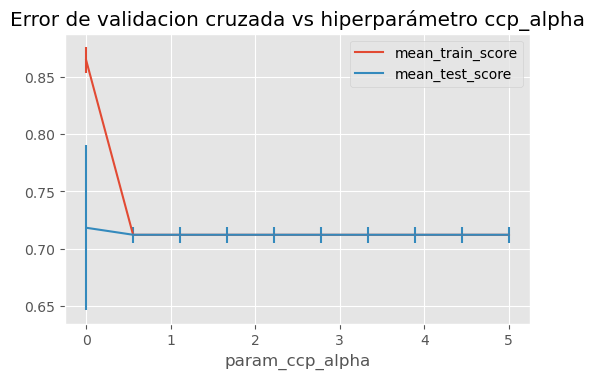

In [51]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
            
                            criterion= 'gini', 
                            splitter='best', 
                            max_depth=34, 
                            max_features='auto', 
                            min_samples_split=2,  
                            min_samples_leaf=4, 
                            min_weight_fraction_leaf=0,
                            random_state=semilla_aleatoria
            
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(train_x, train_y)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [52]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0}

In [53]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
clas_arboles = grid.best_estimator_
print(f"Profundidad del árbol: {clas_arboles.get_depth()}")
print(f"Número de nodos terminales: {clas_arboles.get_n_leaves()}")

Profundidad del árbol: 19
Número de nodos terminales: 38


In [54]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[13,  9],
       [ 9, 47]], dtype=int64)

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        22
           1       0.84      0.84      0.84        56

    accuracy                           0.77        78
   macro avg       0.72      0.72      0.72        78
weighted avg       0.77      0.77      0.77        78



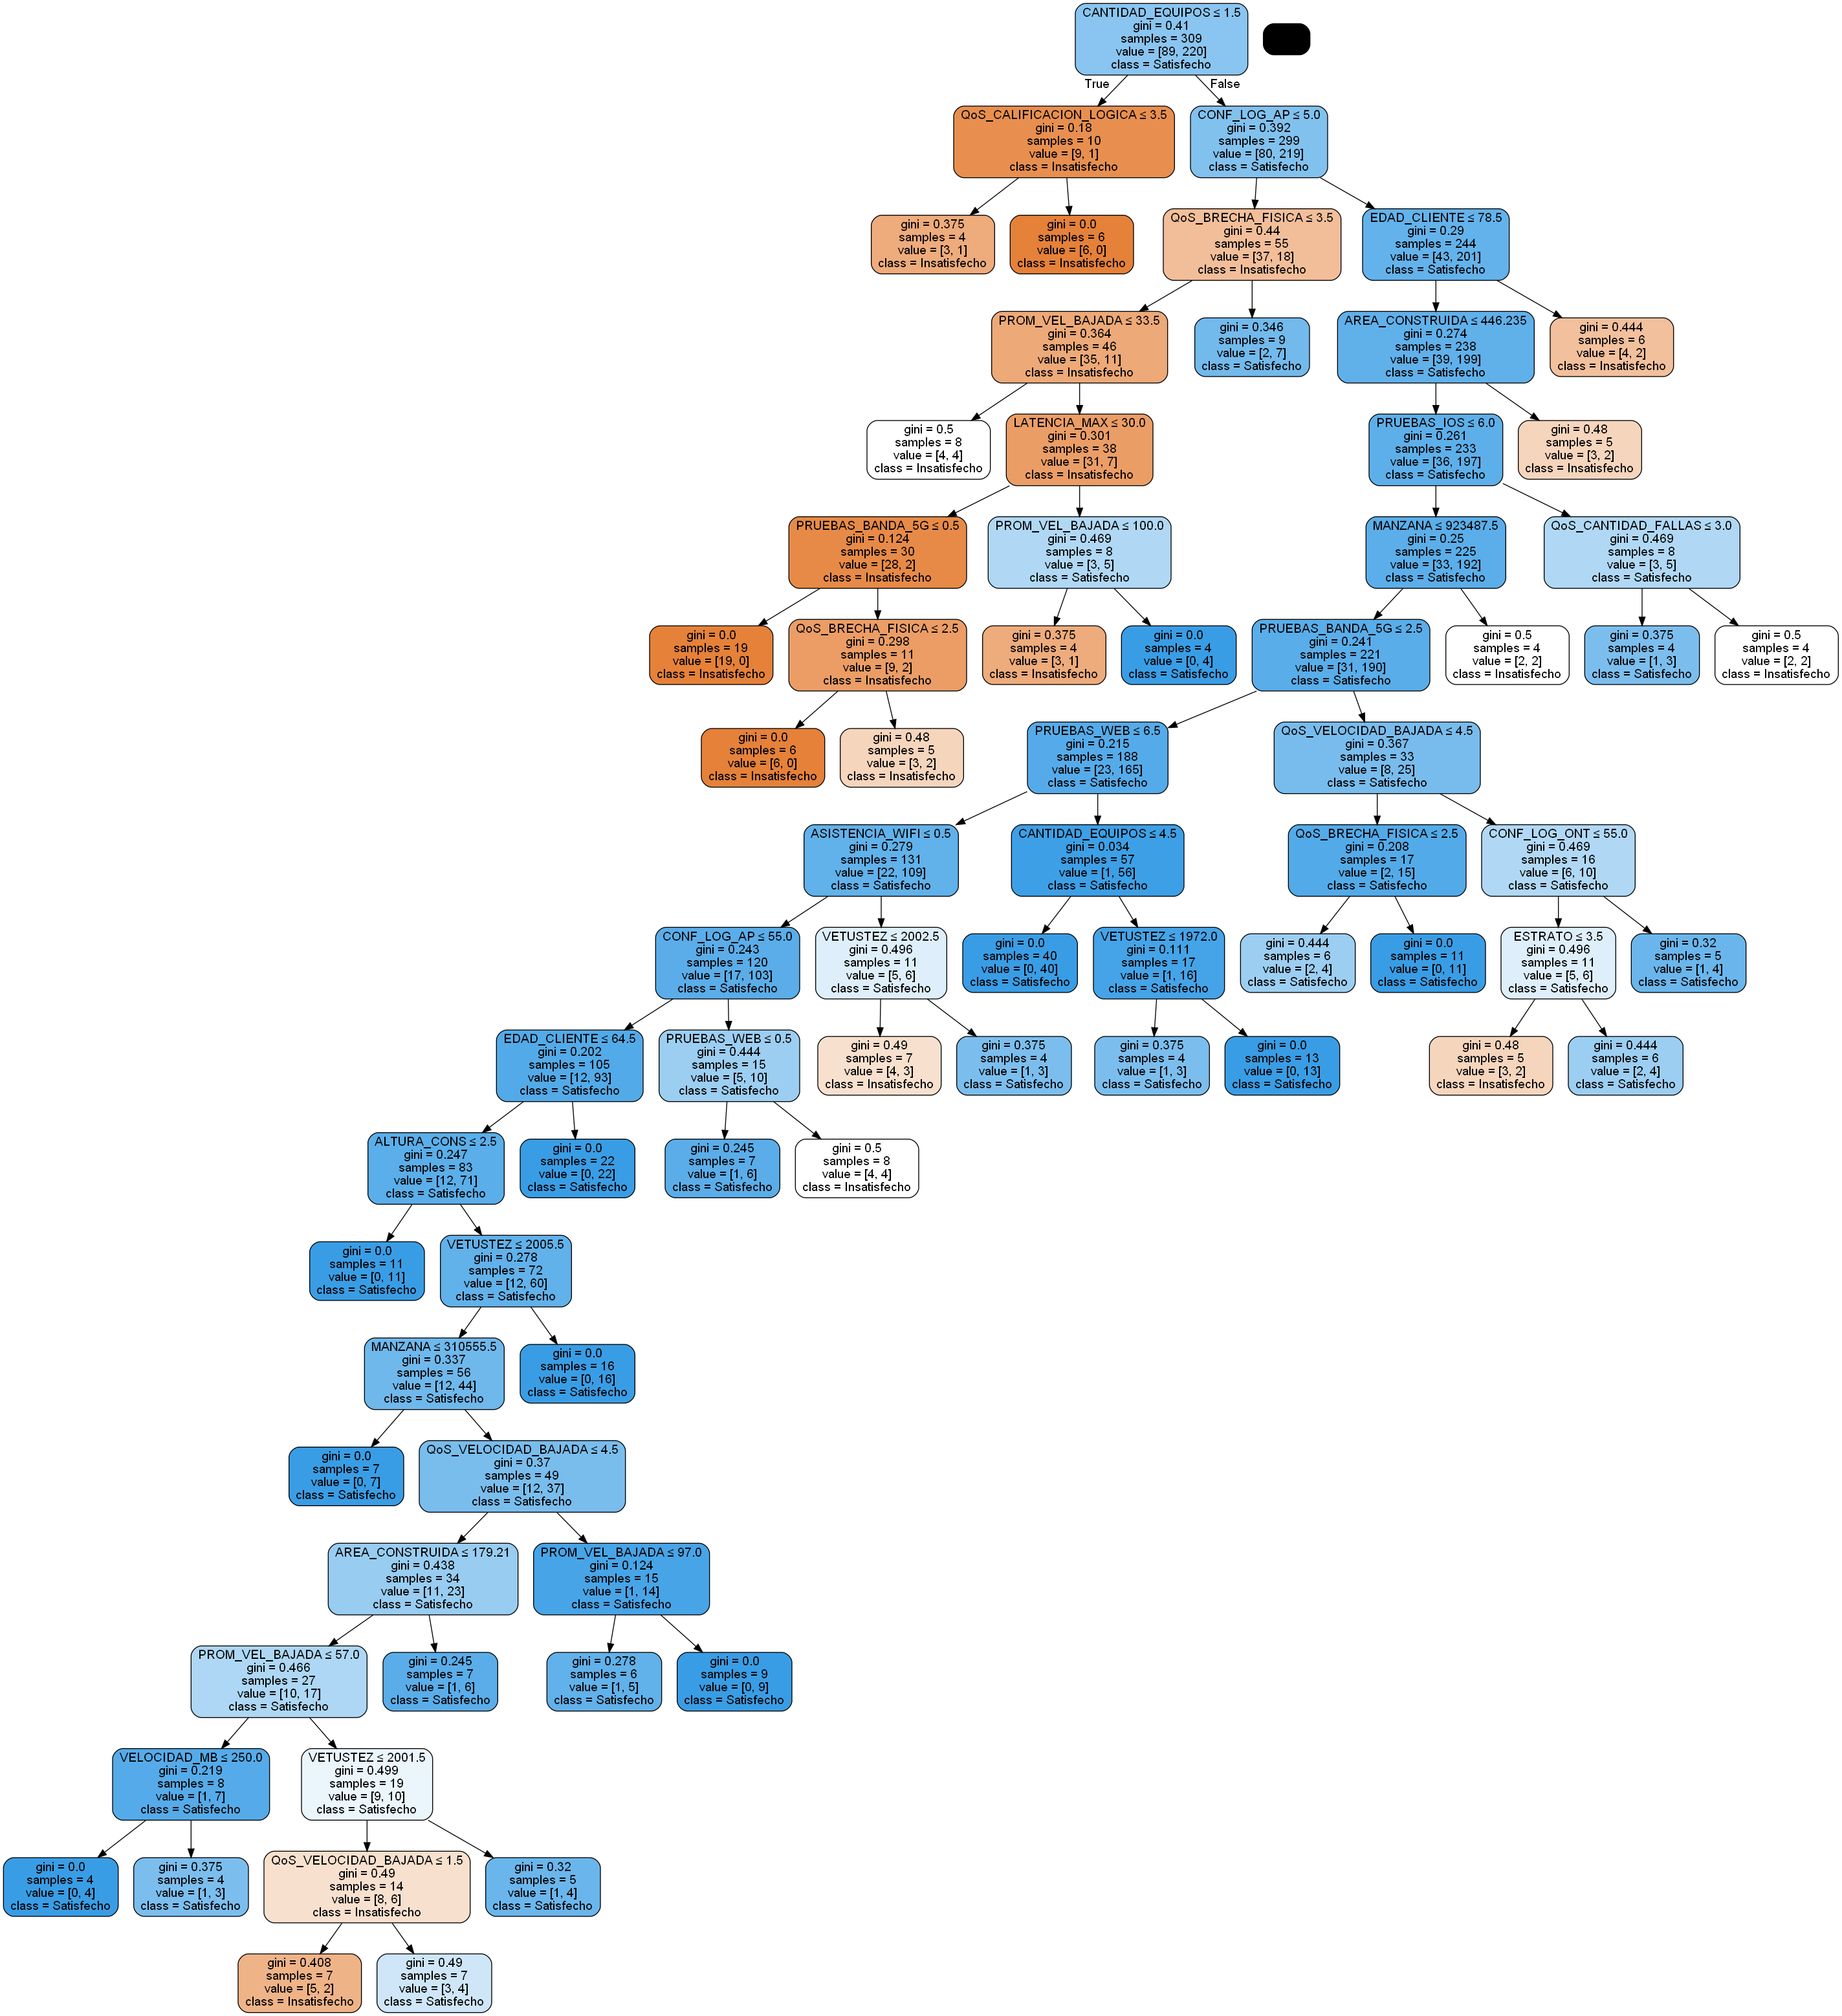

In [55]:
# Visualización de arbol
# ==============================================================================
feature_cols = X.columns

dot_data = StringIO()
export_graphviz(clas_arboles, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['Insatisfecho','Satisfecho']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Satisfecho.png')
Image(graph.create_png())

array([0.72580645, 0.62903226, 0.75806452, 0.74193548, 0.86885246])

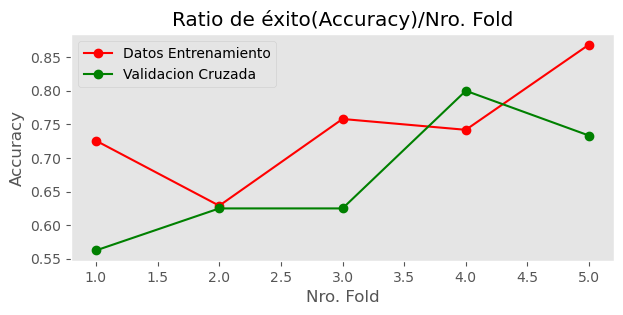

In [56]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

In [57]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': feature_cols,
                             'importancia': clas_arboles.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
33,CONF_LOG_AP,0.336947
7,CANTIDAD_EQUIPOS,0.112710
34,QoS_BRECHA_FISICA,0.087932
30,PROM_VEL_BAJADA,0.074009
31,LATENCIA_MAX,0.056731
0,EDAD_CLIENTE,0.053106
5,VETUSTEZ,0.044197
36,QoS_VELOCIDAD_BAJADA,0.043749
27,PRUEBAS_WEB,0.039607
3,AREA_CONSTRUIDA,0.036283


## Random Forest

In [58]:
# Definición modelo y valor de parametros
# ==============================================================================

# Grid de hiperparámetros evaluados
param_grid = ParameterGrid(
                {'n_estimators'      : [50, 100, 150],
                 'max_features'      : ['auto', None, 5, 7, 9],
                 'max_depth'         : [None, 3, 10, 20],
                 'criterion'         : ['gini'],
                 'min_samples_split' : [0.1, 0.5],
                 'min_samples_leaf'  : [1]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    clas_rndforest = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = semilla_aleatoria,
                ** params
             )
    
    clas_rndforest.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(clas_rndforest.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimator

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo:

Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓


,oob_accuracy,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
24,0.828479,gini,NaN,9,1,0.1,50
114,0.828479,gini,20.0,9,1,0.1,50
110,0.825243,gini,20.0,7,1,0.1,150
84,0.825243,gini,10.0,9,1,0.1,50


In [59]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'ccp_alpha': 0.0} : 0.7181720430107527 accuracy


In [60]:
clas_rndforest_final = grid.best_estimator_

In [61]:
# Error de test del modelo final
# ==============================================================================
predEY_clas_rndforest_final = clas_rndforest_final.predict(X = test_x)
predEY_clas_rndforest_final[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0])

In [62]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_rndforest_final))
clas_rndforest_final=classification_report(test_y,predEY_clas_rndforest_final)
print(clas_report)

array([[13,  9],
       [ 9, 47]], dtype=int64)

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        22
           1       0.84      0.84      0.84        56

    accuracy                           0.77        78
   macro avg       0.72      0.72      0.72        78
weighted avg       0.77      0.77      0.77        78



array([0.75806452, 0.69354839, 0.75806452, 0.72580645, 0.81967213])

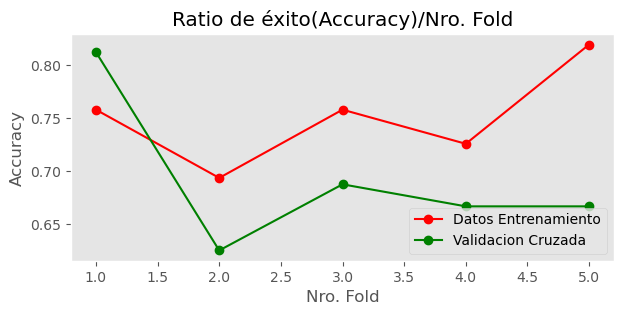

In [63]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_rndforest,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

## SVM

Definir modelo

In [64]:
# Comparación de parametros para modelo - Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 5, 10, 20, 30)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "sigmoid", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 10, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = train_x, y = train_y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.0,0.712043,0.007097,0.711975,0.000766
1,0.000002,0.712043,0.007097,0.711975,0.000766
2,0.000079,0.712043,0.007097,0.711975,0.000766
3,0.003452,0.712043,0.007097,0.711975,0.000766
4,0.151139,0.712043,0.007097,0.711975,0.000766


In [65]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.11522633744856e-08} : 0.7120430107526883 accuracy


In [66]:
# Definición modelo y valor de parametros resultante de la evaluación anterior
# ==============================================================================
# Creación del modelo SVM sigmoide
clas_SVMsig = grid.best_estimator_

### Predicción del modelo

In [67]:
# Predicción
# ==============================================================================
predEY_clas_SVM = clas_SVMsig.predict(test_x)

### Evaluación (métricas)

In [68]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_SVM))
class_report=classification_report(test_y,predEY_clas_SVM)
print(class_report)

array([[ 0, 22],
       [ 0, 56]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.72      1.00      0.84        56

    accuracy                           0.72        78
   macro avg       0.36      0.50      0.42        78
weighted avg       0.52      0.72      0.60        78



#### Visualización

array([0.72580645, 0.67741935, 0.77419355, 0.64516129, 0.73770492])

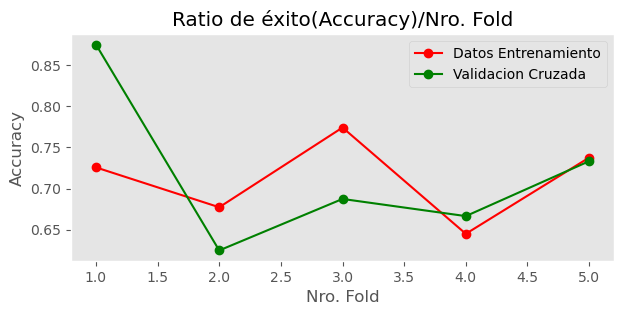

In [69]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_SVMsig,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

### - Modelado con el segundo set de datos

In [168]:
# Definición de conjunto de datos
# ==============================================================================
X = df_base_missing_dropnColumns.drop(columns = ['SATISFECHO']).copy()
y = df_base_missing_dropnColumns['SATISFECHO']

# Dividimos los datos en entrenamiento y el conjunto de datos restante
train_x,test_x,train_y,test_y = train_test_split(X,y, train_size=0.8, random_state=semilla_aleatoria)

## Árbol de Decisión

In [169]:
# Definición modelo y valor de parametros
# ==============================================================================

clas_arboles = DecisionTreeClassifier(criterion= 'gini', splitter='best', max_depth=40, max_features='auto', 
                                      min_samples_split=2,  min_samples_leaf=5, min_weight_fraction_leaf=0.01,
                                      random_state=semilla_aleatoria)

In [170]:
# Entrenamiento
# ==============================================================================
clas_arboles.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=40, max_features='auto', min_samples_leaf=5,
                       min_weight_fraction_leaf=0.01, random_state=1234)

In [171]:
# Predicción
# ==============================================================================
predEY_clas_arb=clas_arboles.predict(test_x)

In [172]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.85      1.00      0.92       360

    accuracy                           0.85       425
   macro avg       0.42      0.50      0.46       425
weighted avg       0.72      0.85      0.78       425



array([0.80588235, 0.81764706, 0.82058824, 0.80825959, 0.83185841])

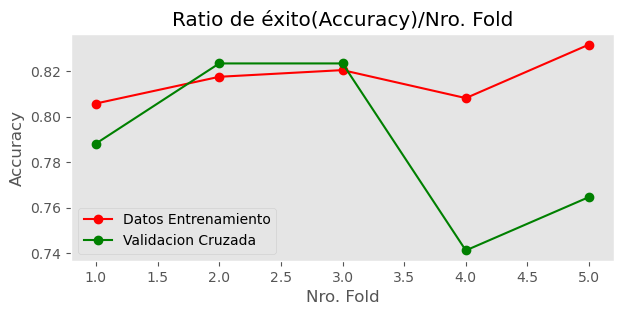

In [173]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

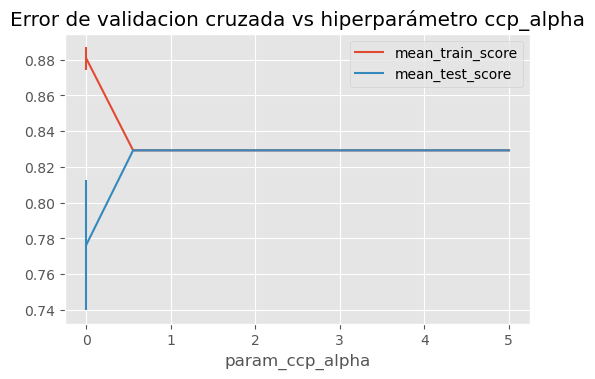

In [146]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
            
                            criterion= 'gini', 
                            splitter='best', 
                            max_depth=20, 
                            max_features='auto', 
                            min_samples_split=2,  
                            min_samples_leaf=5, 
                            min_weight_fraction_leaf=0,
                            random_state=semilla_aleatoria
            
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(train_x, train_y)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [147]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.5555555555555556}

In [148]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
clas_arboles = grid.best_estimator_
print(f"Profundidad del árbol: {clas_arboles.get_depth()}")
print(f"Número de nodos terminales: {clas_arboles.get_n_leaves()}")

Profundidad del árbol: 0
Número de nodos terminales: 1


In [149]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[  7,  58],
       [ 13, 347]], dtype=int64)

              precision    recall  f1-score   support

           0       0.35      0.11      0.16        65
           1       0.86      0.96      0.91       360

    accuracy                           0.83       425
   macro avg       0.60      0.54      0.54       425
weighted avg       0.78      0.83      0.79       425



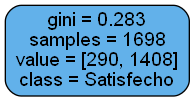

In [150]:
# Visualización de arbol
# ==============================================================================
feature_cols = X.columns

dot_data = StringIO()
export_graphviz(clas_arboles, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['Insatisfecho','Satisfecho']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Satisfecho.png')
Image(graph.create_png())

array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

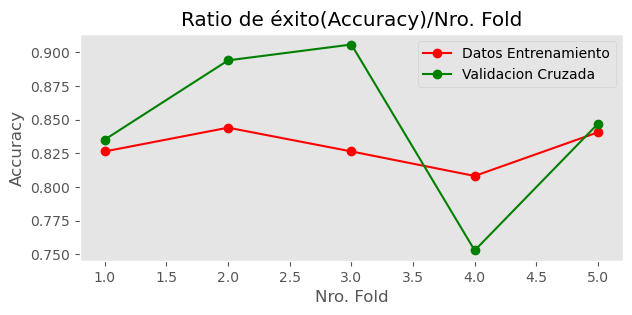

In [80]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

In [81]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': feature_cols,
                             'importancia': clas_arboles.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,VELOCIDAD_MB,0.0
29,PREDIO_PH,0.0
22,PLATAFORMAS,0.0
23,CONF_LOG_ONT,0.0
24,QoS_BRECHA_FISICA,0.0
25,QoS_CANTIDAD_FALLAS,0.0
26,QoS_VELOCIDAD_BAJADA,0.0
27,QoS_DIFERENCIA_ACS,0.0
28,QoS_CALIFICACION_LOGICA,0.0
30,ONT_ZTE_SINGLE,0.0


### Random Forest

In [82]:
# Definición modelo y valor de parametros
# ==============================================================================

# Grid de hiperparámetros evaluados
param_grid = ParameterGrid(
                {'n_estimators'      : [50, 100, 150],
                 'max_features'      : ['auto', None, 5, 7, 9],
                 'max_depth'         : [None, 3, 10, 20],
                 'criterion'         : ['gini'],
                 'min_samples_split' : [0.1, 0.5],
                 'min_samples_leaf'  : [1]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    clas_rndforest = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = semilla_aleatoria,
                ** params
             )
    
    clas_rndforest.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(clas_rndforest.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimator

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo:

Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓


,oob_accuracy,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
114,0.8298,gini,20.0,9,1,0.1,50
84,0.8298,gini,10.0,9,1,0.1,50
68,0.8298,gini,10.0,None,1,0.1,150
24,0.8298,gini,NaN,9,1,0.1,50


In [83]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'ccp_alpha': 0.5555555555555556} : 0.8292098851374871 accuracy


In [84]:
clas_rndforest_final = grid.best_estimator_

In [85]:
# Error de test del modelo final
# ==============================================================================
predEY_clas_rndforest_final = clas_rndforest_final.predict(X = test_x)
predEY_clas_rndforest_final[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [86]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_rndforest_final))
clas_rndforest_final=classification_report(test_y,predEY_clas_rndforest_final)
print(clas_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.85      1.00      0.92       360

    accuracy                           0.85       425
   macro avg       0.42      0.50      0.46       425
weighted avg       0.72      0.85      0.78       425



array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

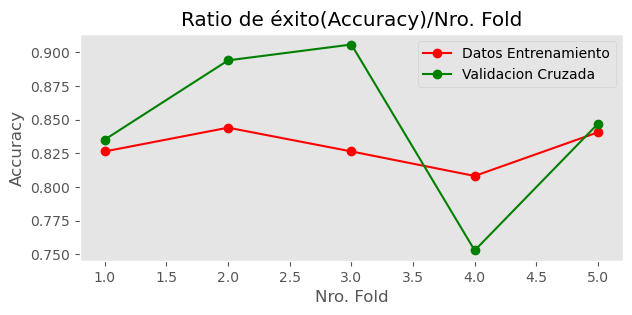

In [87]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_rndforest,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

### SVM

In [88]:
# Comparación de parametros para modelo - Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 5, 10, 20, 30)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "sigmoid", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 10, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = train_x, y = train_y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.0,0.829210,0.000404,0.829211,0.000045
1,0.000002,0.829210,0.000404,0.829211,0.000045
2,0.000079,0.829210,0.000404,0.829211,0.000045
3,0.003452,0.829210,0.000404,0.829211,0.000045
4,0.151139,0.828033,0.002286,0.828622,0.000194


In [89]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.11522633744856e-08} : 0.8292098851374871 accuracy


In [90]:
# Definición modelo y valor de parametros resultante de la evaluación anterior
# ==============================================================================
# Creación del modelo SVM sigmoide
clas_SVMsig = grid.best_estimator_

In [91]:
# Predicción
# ==============================================================================
predEY_clas_SVM = clas_SVMsig.predict(test_x)

In [92]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_SVM))
class_report=classification_report(test_y,predEY_clas_SVM)
print(class_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.85      1.00      0.92       360

    accuracy                           0.85       425
   macro avg       0.42      0.50      0.46       425
weighted avg       0.72      0.85      0.78       425



array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

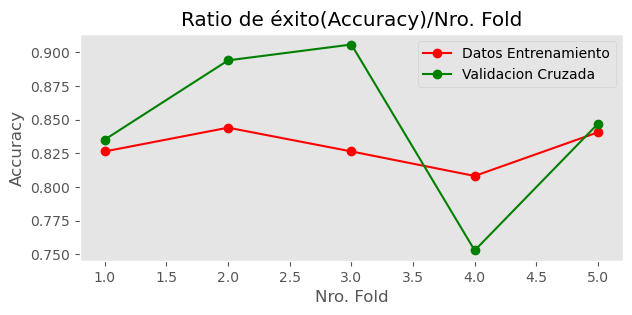

In [93]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_SVMsig,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

### - Modelado con el tercer set de datos

In [197]:
# Definición de conjunto de datos
# ==============================================================================
X = df_base_missing_mean.drop(columns = ['SATISFECHO']).copy()
y = df_base_missing_mean['SATISFECHO']

# Dividimos los datos en entrenamiento y el conjunto de datos restante
train_x,test_x,train_y,test_y = train_test_split(X,y, train_size=0.8, random_state=semilla_aleatoria)

## Árbol de Decisión

In [198]:
# Definición modelo y valor de parametros
# ==============================================================================

clas_arboles = DecisionTreeClassifier(criterion= 'gini', splitter='best', max_depth=19, max_features='auto', 
                                      min_samples_split=2,  min_samples_leaf=4, min_weight_fraction_leaf=0.01,
                                      random_state=semilla_aleatoria)

In [199]:
# Entrenamiento
# ==============================================================================
clas_arboles.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=19, max_features='auto', min_samples_leaf=4,
                       min_weight_fraction_leaf=0.01, random_state=1234)

In [200]:
# Predicción
# ==============================================================================
predEY_clas_arb=clas_arboles.predict(test_x)

In [201]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[ 11,  54],
       [  8, 352]], dtype=int64)

              precision    recall  f1-score   support

           0       0.58      0.17      0.26        65
           1       0.87      0.98      0.92       360

    accuracy                           0.85       425
   macro avg       0.72      0.57      0.59       425
weighted avg       0.82      0.85      0.82       425



array([0.85      , 0.86764706, 0.84705882, 0.79351032, 0.84365782])

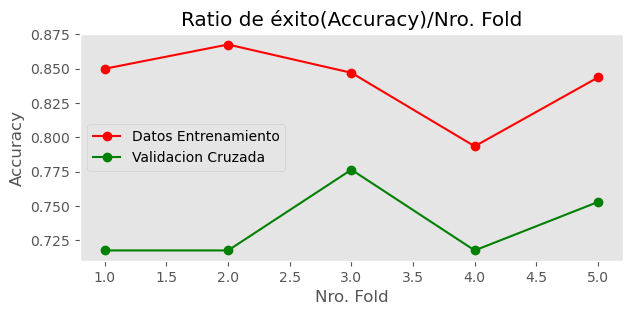

In [202]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

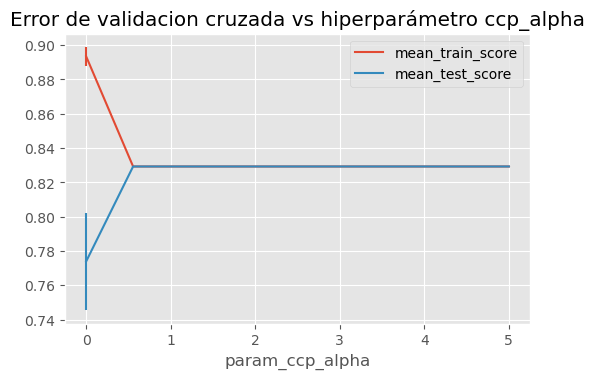

In [180]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
            
                            criterion= 'gini', 
                            splitter='best', 
                            max_depth=20, 
                            max_features='auto', 
                            min_samples_split=2,  
                            min_samples_leaf=4, 
                            min_weight_fraction_leaf=0,
                            random_state=semilla_aleatoria
            
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(train_x, train_y)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [181]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.5555555555555556}

In [182]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
clas_arboles = grid.best_estimator_
print(f"Profundidad del árbol: {clas_arboles.get_depth()}")
print(f"Número de nodos terminales: {clas_arboles.get_n_leaves()}")

Profundidad del árbol: 0
Número de nodos terminales: 1


In [183]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[ 11,  54],
       [  8, 352]], dtype=int64)

              precision    recall  f1-score   support

           0       0.58      0.17      0.26        65
           1       0.87      0.98      0.92       360

    accuracy                           0.85       425
   macro avg       0.72      0.57      0.59       425
weighted avg       0.82      0.85      0.82       425



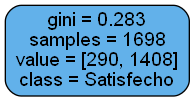

In [184]:
# Visualización de arbol
# ==============================================================================
feature_cols = X.columns

dot_data = StringIO()
export_graphviz(clas_arboles, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['Insatisfecho','Satisfecho']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Satisfecho.png')
Image(graph.create_png())

array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

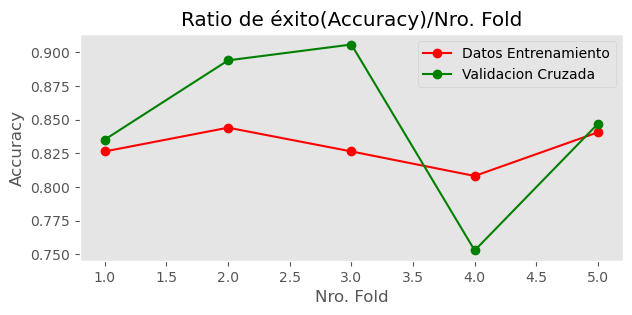

In [185]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

In [105]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': feature_cols,
                             'importancia': clas_arboles.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,EDAD_CLIENTE,0.0
25,PRUEBAS_DESKTOP,0.0
27,PRUEBAS_WEB,0.0
28,PRUEBAS_BANDA_2G,0.0
29,PRUEBAS_BANDA_5G,0.0
30,PROM_VEL_BAJADA,0.0
31,LATENCIA_MAX,0.0
32,CONF_LOG_ONT,0.0
33,CONF_LOG_AP,0.0
34,QoS_BRECHA_FISICA,0.0


### Random Forest

In [106]:
# Definición modelo y valor de parametros
# ==============================================================================

# Grid de hiperparámetros evaluados
param_grid = ParameterGrid(
                {'n_estimators'      : [50, 100, 150],
                 'max_features'      : ['auto', None, 5, 7, 9],
                 'max_depth'         : [None, 3, 10, 20],
                 'criterion'         : ['gini'],
                 'min_samples_split' : [0.1, 0.5],
                 'min_samples_leaf'  : [1]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    clas_rndforest = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = semilla_aleatoria,
                ** params
             )
    
    clas_rndforest.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(clas_rndforest.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimator

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo:

Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓


,oob_accuracy,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
97,0.851001,gini,20.0,None,1,0.1,100
100,0.851001,gini,20.0,None,1,0.5,100
67,0.851001,gini,10.0,None,1,0.1,100
68,0.851001,gini,10.0,None,1,0.1,150


In [107]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'ccp_alpha': 0.5555555555555556} : 0.8292098851374871 accuracy


In [203]:
clas_rndforest_final = grid.best_estimator_

In [204]:
# Error de test del modelo final
# ==============================================================================
predEY_clas_rndforest_final = clas_rndforest_final.predict(X = test_x)
predEY_clas_rndforest_final[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [205]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_rndforest_final))
clas_rndforest_final=classification_report(test_y,predEY_clas_rndforest_final)
print(clas_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.58      0.17      0.26        65
           1       0.87      0.98      0.92       360

    accuracy                           0.85       425
   macro avg       0.72      0.57      0.59       425
weighted avg       0.82      0.85      0.82       425



array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

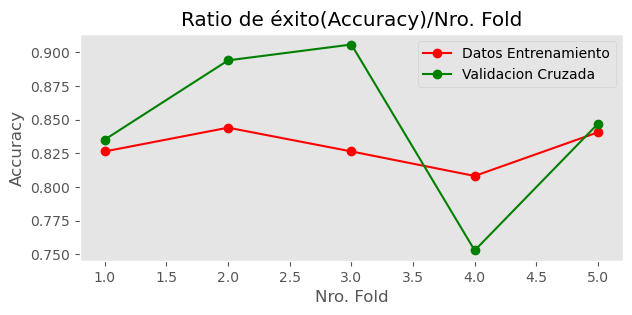

In [206]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_rndforest,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

### SVM

In [112]:
# Comparación de parametros para modelo - Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 5, 10, 20, 30)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "sigmoid", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 10, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = train_x, y = train_y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.0,0.829210,0.000404,0.829211,0.000045
1,0.000002,0.829210,0.000404,0.829211,0.000045
2,0.000079,0.829210,0.000404,0.829211,0.000045
3,0.003452,0.829210,0.000404,0.829211,0.000045
4,0.151139,0.828033,0.002286,0.828622,0.000194


In [113]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.11522633744856e-08} : 0.8292098851374871 accuracy


In [207]:
# Definición modelo y valor de parametros resultante de la evaluación anterior
# ==============================================================================
# Creación del modelo SVM sigmoide
clas_SVMsig = grid.best_estimator_

In [208]:
# Predicción
# ==============================================================================
predEY_clas_SVM = clas_SVMsig.predict(test_x)

In [209]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_SVM))
class_report=classification_report(test_y,predEY_clas_SVM)
print(class_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.85      1.00      0.92       360

    accuracy                           0.85       425
   macro avg       0.42      0.50      0.46       425
weighted avg       0.72      0.85      0.78       425



array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

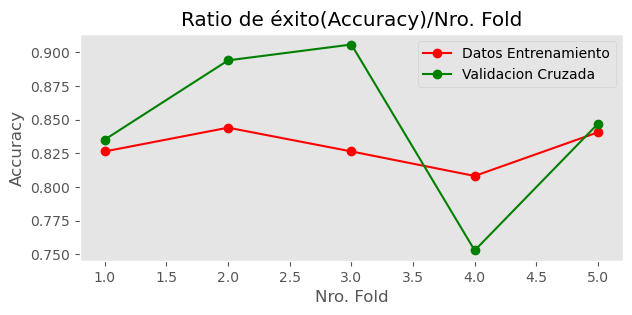

In [210]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_SVMsig,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

### - Modelado con el cuarto set de datos

In [224]:
# Definición de conjunto de datos
# ==============================================================================
X = df_base_missing_interpo.drop(columns = ['SATISFECHO']).copy()
y = df_base_missing_interpo['SATISFECHO']

# Dividimos los datos en entrenamiento y el conjunto de datos restante
train_x,test_x,train_y,test_y = train_test_split(X,y, train_size=0.8, random_state=semilla_aleatoria)

## Árbol de Decisión

In [225]:
# Definición modelo y valor de parametros
# ==============================================================================

clas_arboles = DecisionTreeClassifier(criterion= 'gini', splitter='best', max_depth=19, max_features='auto', 
                                      min_samples_split=2,  min_samples_leaf=4, min_weight_fraction_leaf=0.01,
                                      random_state=semilla_aleatoria)

In [226]:
# Entrenamiento
# ==============================================================================
clas_arboles.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=19, max_features='auto', min_samples_leaf=4,
                       min_weight_fraction_leaf=0.01, random_state=1234)

In [227]:
# Predicción
# ==============================================================================
predEY_clas_arb=clas_arboles.predict(test_x)

In [228]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[  7,  58],
       [ 13, 347]], dtype=int64)

              precision    recall  f1-score   support

           0       0.35      0.11      0.16        65
           1       0.86      0.96      0.91       360

    accuracy                           0.83       425
   macro avg       0.60      0.54      0.54       425
weighted avg       0.78      0.83      0.79       425



array([0.80588235, 0.83235294, 0.81764706, 0.81710914, 0.84955752])

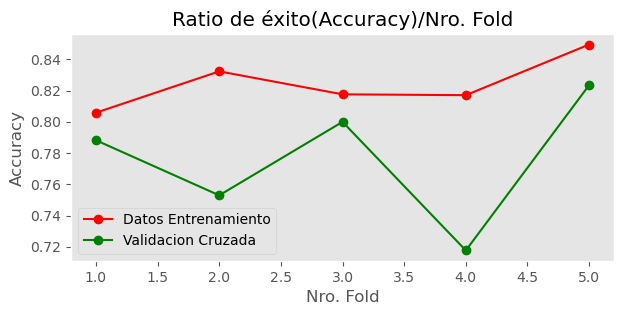

In [229]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

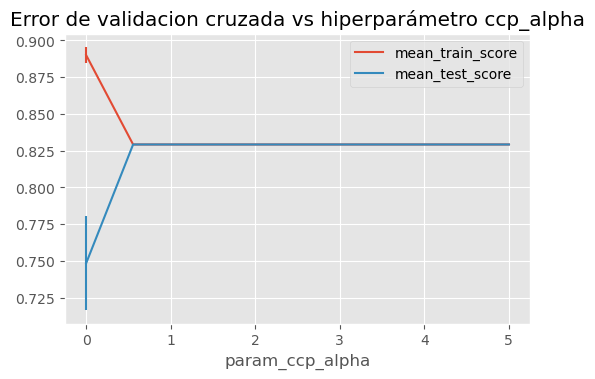

In [217]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
            
                            criterion= 'gini', 
                            splitter='best', 
                            max_depth=20, 
                            max_features='auto', 
                            min_samples_split=2,  
                            min_samples_leaf=4, 
                            min_weight_fraction_leaf=0,
                            random_state=semilla_aleatoria
            
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(train_x, train_y)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [218]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.5555555555555556}

In [219]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
clas_arboles = grid.best_estimator_
print(f"Profundidad del árbol: {clas_arboles.get_depth()}")
print(f"Número de nodos terminales: {clas_arboles.get_n_leaves()}")

Profundidad del árbol: 0
Número de nodos terminales: 1


In [220]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_arb))
clas_report=classification_report(test_y,predEY_clas_arb)
print(clas_report)

array([[  7,  58],
       [ 13, 347]], dtype=int64)

              precision    recall  f1-score   support

           0       0.35      0.11      0.16        65
           1       0.86      0.96      0.91       360

    accuracy                           0.83       425
   macro avg       0.60      0.54      0.54       425
weighted avg       0.78      0.83      0.79       425



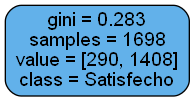

In [221]:
# Visualización de arbol
# ==============================================================================
feature_cols = X.columns

dot_data = StringIO()
export_graphviz(clas_arboles, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['Insatisfecho','Satisfecho']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Satisfecho.png')
Image(graph.create_png())

array([0.80588235, 0.83235294, 0.81764706, 0.81710914, 0.84955752])

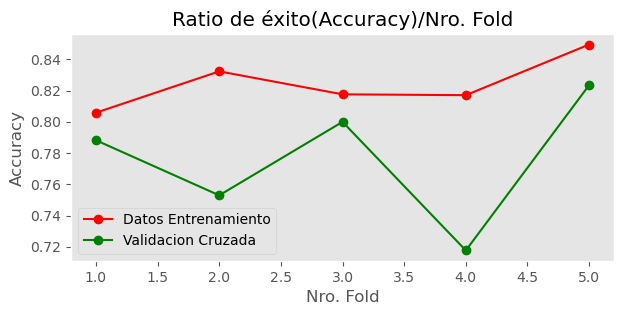

In [230]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

In [231]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': feature_cols,
                             'importancia': clas_arboles.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
33,CONF_LOG_AP,0.393315
3,AREA_CONSTRUIDA,0.133022
2,MANZANA,0.070103
27,PRUEBAS_WEB,0.054197
0,EDAD_CLIENTE,0.053750
31,LATENCIA_MAX,0.039379
1,VELOCIDAD_MB,0.037125
30,PROM_VEL_BAJADA,0.034588
38,QoS_CALIFICACION_LOGICA,0.031162
10,ASISTENCIA_GNRAL,0.029515


### Random Forest

In [232]:
# Definición modelo y valor de parametros
# ==============================================================================

# Grid de hiperparámetros evaluados
param_grid = ParameterGrid(
                {'n_estimators'      : [50, 100, 150],
                 'max_features'      : ['auto', None, 5, 7, 9],
                 'max_depth'         : [None, 3, 10, 20],
                 'criterion'         : ['gini'],
                 'min_samples_split' : [0.1, 0.5],
                 'min_samples_leaf'  : [1]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    clas_rndforest = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = semilla_aleatoria,
                ** params
             )
    
    clas_rndforest.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(clas_rndforest.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimator

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓
Modelo:

Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.5, 'n_estimators': 150} ✓


,oob_accuracy,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
69,0.839223,gini,10.0,None,1,0.5,50
10,0.839223,gini,NaN,None,1,0.5,100
41,0.839223,gini,3.0,None,1,0.5,150
40,0.839223,gini,3.0,None,1,0.5,100


In [233]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'ccp_alpha': 0.5555555555555556} : 0.8292098851374871 accuracy


In [234]:
clas_rndforest_final = grid.best_estimator_

In [235]:
# Error de test del modelo final
# ==============================================================================
predEY_clas_rndforest_final = clas_rndforest_final.predict(X = test_x)
predEY_clas_rndforest_final[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [236]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_rndforest_final))
clas_rndforest_final=classification_report(test_y,predEY_clas_rndforest_final)
print(clas_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.35      0.11      0.16        65
           1       0.86      0.96      0.91       360

    accuracy                           0.83       425
   macro avg       0.60      0.54      0.54       425
weighted avg       0.78      0.83      0.79       425



array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

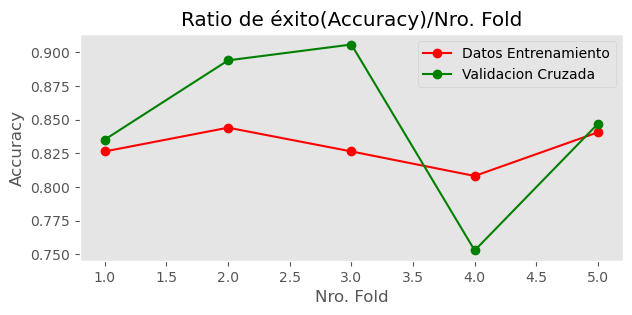

In [237]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_rndforest,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

### SVM

In [238]:
# Comparación de parametros para modelo - Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 5, 10, 20, 30)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "sigmoid", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 10, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = train_x, y = train_y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.0,0.829210,0.000404,0.829211,0.000045
1,0.000002,0.829210,0.000404,0.829211,0.000045
2,0.000079,0.829210,0.000404,0.829211,0.000045
3,0.003452,0.829210,0.000404,0.829211,0.000045
4,0.151139,0.828033,0.002286,0.828622,0.000194


In [239]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.11522633744856e-08} : 0.8292098851374871 accuracy


In [240]:
# Definición modelo y valor de parametros resultante de la evaluación anterior
# ==============================================================================
# Creación del modelo SVM sigmoide
clas_SVMsig = grid.best_estimator_

In [241]:
# Predicción
# ==============================================================================
predEY_clas_SVM = clas_SVMsig.predict(test_x)

In [242]:
# Matriz de confusión
# ==============================================================================
display(confusion_matrix(test_y,predEY_clas_SVM))
class_report=classification_report(test_y,predEY_clas_SVM)
print(class_report)

array([[  0,  65],
       [  0, 360]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.85      1.00      0.92       360

    accuracy                           0.85       425
   macro avg       0.42      0.50      0.46       425
weighted avg       0.72      0.85      0.78       425



array([0.82647059, 0.84411765, 0.82647059, 0.80825959, 0.84070796])

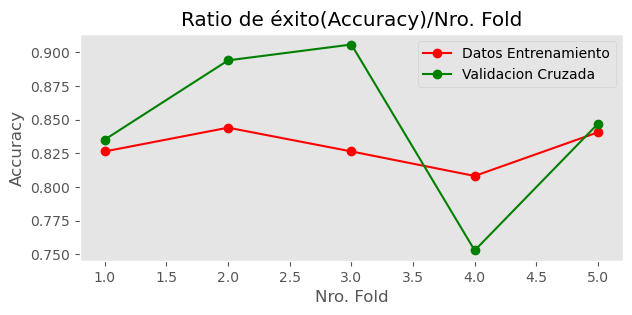

In [243]:
# Validación cruzada accuracy score con mínimo 5 folds.
# ==============================================================================
graficar_accuracy_scores(clas_SVMsig,train_x,train_y,test_x,test_y,nparts=5,jobs=2)